# Tese case: groundwater flow modeling


## Load basic modules

In [1]:
import numpy as np
import numba as nb
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from SALib.sample import saltelli
from SALib.analyze import sobol

np.random.seed(2**30)
plt.style.use('default')

## Define the process models for recharge and snow melt processes

In [2]:
def model_R1(a):
    """
    Compute recharge[m/d] using recharge model R1 by Chaturvedi(1936)
    
    """
    return a * (P - 14)**0.5 * 25.4 * 0.001 / 365

def model_R2(b):
    """
    Compute recharge[m/d] using recharge model R2 by Krishna Rao (1970)
    
    """
    return b * (P - 15.7) * 25.4 * 0.001 / 365

def model_M1(f1):
    """
    Compute river stage h2 [m] using degree-day method
 
    """
    M = f1 * (Ta - Tm)
    Q = Csn * M * SVC * A * 0.001 / 86400
    h2 = 0.3 * Q**0.6 + z0
    
    return h2

def model_M2(f2, r):
    """
    Compute river stage h2 [m] using restricted degree-day radiation balance approach

    """
    M = f2 * (Ta - Tm) + r * Rn
    Q = Csn * M * SVC * A * 0.001 / 86400
    h2 = 0.3 * Q**0.6 + z0
    
    return h2

## Define analytical solutions for head location of groundwater divide, and discharge 

In [3]:
def analytical_hds_solver(w, k1, k2, h2, x):
    """
    Compute hydraulic heads [m] at a given location x using anaytical solution

    """
    C1 = (h1**2 - h2**2 - w / k1 * x0**2 + w / k2 * x0**2 - w / k2 * L**2) / (k1 / k2 * x0 - k1 / k2 * L - x0)
    C2 = h1**2
    C3 = k1 / k2 * C1
    C4 = h2**2 + w / k2 * L**2 - C3 * L
    
    if x <= x0:
        return np.sqrt(-w / k1 * x**2 + C1 * x + C2)
    else:
        return np.sqrt(-w / k2 * x**2 + C3 * x + C4)
        
def analytical_dvd_solver(w, k1, k2, h2):
    """
    Compute hydraulic heads [m] at specified discreted points using anaytical solution

    """
    C1 = (h1**2 - h2**2 - w / k1 * x0**2 + w / k2 * x0**2 - w / k2 * L**2) / (k1 / k2 * x0 - k1 / k2 * L - x0)

    return k1 * C1 / (2 * w)

def analytical_dsc_solver(w, k1, k2, h2, x):
    """
    Compute discharge per unit [m2/d] at a given location x using anaytical solution
    
    """
    C1 = (h1**2 - h2**2 - w / k1 * x0**2 + w / k2 * x0**2 - w / k2 * L**2) / (k1 / k2 * x0 - k1 / k2 * L - x0)

    return w * x - k1 * C1 / 2

## Global parameter settings

In [4]:
# Parameters for snow melt process
P = 60                # Precipation in inch/yr
Ta = 7                # Average temperature for a given day in degree 
Tm = 0                # Critical snow melt point in degree
Csn = 0.8             # Runoff confficient
SVC = 0.7             # Snow cover fraction 
A = 2000 * 1e6        # Upper catchment area in  km2
Rn = 80               # Surface radiation in w/m2

# Left boundary condition
h1 = 300              # Head in the left 

# Domain information
z0 = 289              # Elevation of river bed in meters    
L = 10000   
x0 = 7000
Nx = 21
qid = 14
X = np.linspace(0, L, Nx, endpoint=True)

# Parameter bounds and distributions
bounds = {'a': [2.0, 0.4],
          'b': [0.2, 0.5],
          'hk': [2.9, 0.5],
          'k1': [2.6, 0.3],
          'k2': [3.2, 0.3],
          'f1': [3.5, 0.75],
          'f2': [2.5, 0.3],
          'r': [0.3, 0.05]}

dists = {'a': 'norm',
         'b': 'unif',
         'hk': 'lognorm',
         'k1': 'lognorm',
         'k2': 'lognorm',
         'f1': 'norm',
         'f2': 'norm',
         'r': 'norm'}

## Plot the outputs from the alternative process models

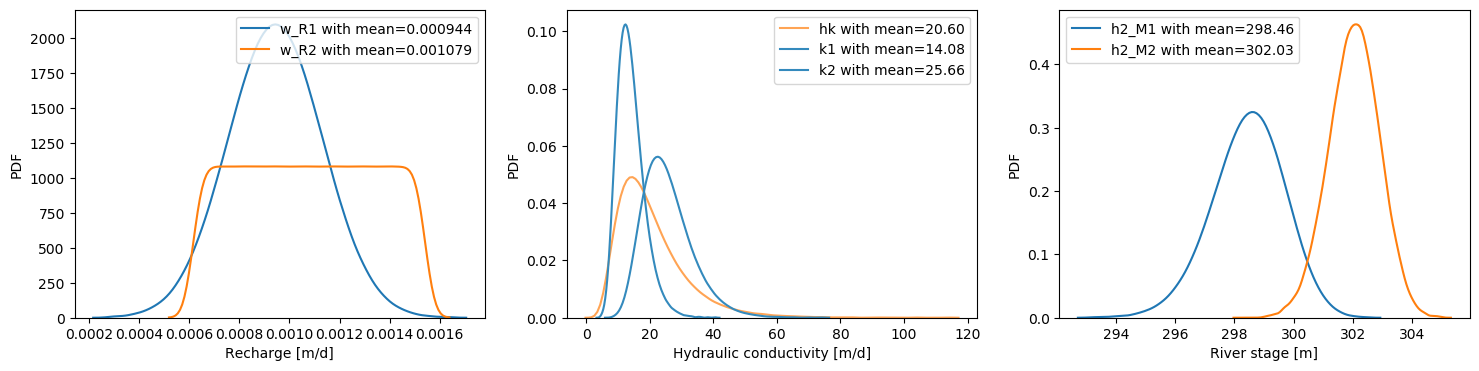

In [5]:
# Define the inputs
problem = {'num_vars': 8,
           'names': ['a', 'b', 'hk', 'k1', 'k2', 'f1', 'f2', 'r'],
           'bounds': [bounds['a'], bounds['b'], bounds['hk'], bounds['k1'], bounds['k2'], bounds['f1'], bounds['f2'], bounds['r']],
           'dists': [dists['a'], dists['b'], dists['hk'], dists['k1'], dists['k2'], dists['f1'], dists['f2'], dists['r']]
           }

# Generate samples
param_values = saltelli.sample(problem, 5000, calc_second_order=False)

# Compute the rehcagre
w_R1 = model_R1(param_values[:, 0])
w_R2 = model_R2(param_values[:, 1])

# Set hydraulic concuctivity
hk = param_values[:, 2]
k1 = param_values[:, 3]
k2 = param_values[:, 4]

# Compute the river stage at the right condiction
h2_M1 = model_M1(param_values[:, 5])
h2_M2 = model_M2(param_values[:, 6], param_values[:, 7])

# Plot the PDFs
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.kdeplot(w_R1, label='w_R1 with mean=%.6f' %np.mean(w_R1))
sns.kdeplot(w_R2, label='w_R2 with mean=%.6f' %np.mean(w_R2))
plt.xlabel('Recharge [m/d]')
plt.ylabel('PDF')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(hk, label='hk with mean=%.2f' %np.mean(hk), color='#FFA454')
sns.kdeplot(k1, label='k1 with mean=%.2f' %np.mean(k1), color='#348ABD')
sns.kdeplot(k2, label='k2 with mean=%.2f' %np.mean(k2), color='#348ABD')
plt.xlabel('Hydraulic conductivity [m/d]')
plt.ylabel('PDF')

plt.subplot(1, 3, 3)
sns.kdeplot(h2_M1, label='h2_M1 with mean=%.2f' %np.mean(h2_M1))
sns.kdeplot(h2_M2, label='h2_M2 with mean=%.2f' %np.mean(h2_M2))
plt.xlabel('River stage [m]')
plt.ylabel('PDF')

plt.show()

## Parameter sensitivity under individual system models

### MODEL: R1G1M1

In [6]:
# Define the model inputs
problem = {'num_vars': 3,
           'names': ['a', 'hk', 'f1'],
           'bounds': [bounds['a'], bounds['hk'], bounds['f1']],
           'dists': [dists['a'], dists['hk'], dists['f1']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R1(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 1]
h2 = model_M1(param_values[:, 2])

# Evalauate model and perform sensitivity analysis at given locations
q_R1G1M1 = {}     
Si_R1G1M1 = {}
for ix, x in zip(range(Nx), X):
    q_R1G1M1[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    if ix == qid:
        print('Parameter sensitivity at x=7000m: \n')
        Si_R1G1M1[ix] = sobol.analyze(problem, q_R1G1M1[ix], print_to_console=True, calc_second_order=True)
    else:
        Si_R1G1M1[ix] = sobol.analyze(problem, q_R1G1M1[ix], print_to_console=False, calc_second_order=True)

Parameter sensitivity at x=7000m: 

Parameter S1 S1_conf ST ST_conf
a 0.124092 0.009743 0.123748 0.005768
hk 0.224692 0.027404 0.368737 0.021746
f1 0.507775 0.028269 0.660565 0.030628

Parameter_1 Parameter_2 S2 S2_conf
a hk 0.000069 0.013174
a f1 -0.001095 0.015704
hk f1 0.138214 0.059662


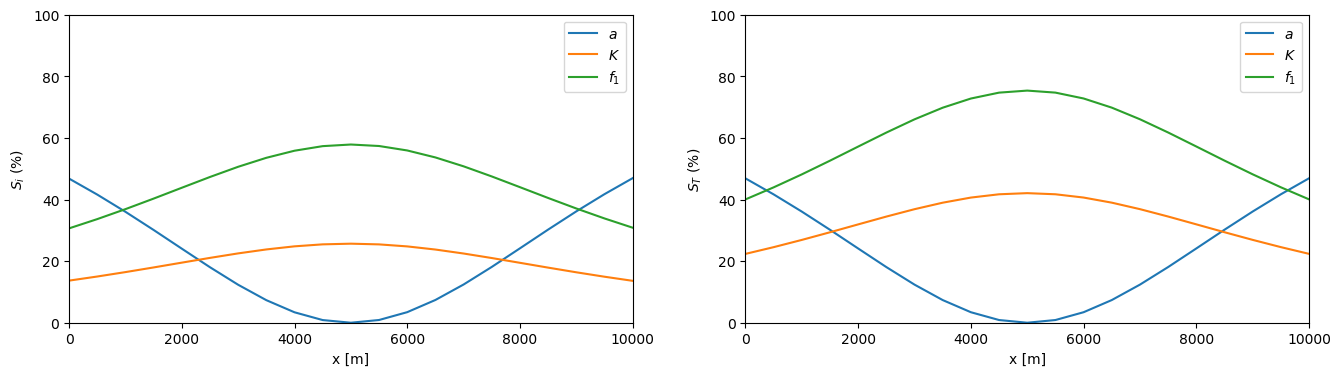

In [7]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R1G1M1[ix]['S1'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [Si_R1G1M1[ix]['S1'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [Si_R1G1M1[ix]['S1'][2]* 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R1G1M1[ix]['ST'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [Si_R1G1M1[ix]['ST'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [Si_R1G1M1[ix]['ST'][2]* 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R1G1M2

In [8]:
# Define the model inputs
problem = {'num_vars': 4,
           'names': ['a', 'hk', 'f2', 'r'],
           'bounds': [bounds['a'], bounds['hk'], bounds['f2'], bounds['r']],
           'dists': [dists['a'], dists['hk'], dists['f2'], dists['r']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R1(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 1]
h2 = model_M2(param_values[:, 2], param_values[:, 3])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R1G1M2 = {}     
Si_R1G1M2 = {}
for ix, x in zip(range(Nx), X):
    q_R1G1M2[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    if ix == qid:
        print('Parameter sensitivity at x=7000m: \n')
        Si_R1G1M2[ix] = sobol.analyze(problem, q_R1G1M2[ix], print_to_console=True, calc_second_order=True)
    else:
        Si_R1G1M2[ix] = sobol.analyze(problem, q_R1G1M2[ix], print_to_console=False, calc_second_order=True)

Parameter sensitivity at x=7000m: 

Parameter S1 S1_conf ST ST_conf
a 0.150770 0.011801 0.149793 0.006786
hk 0.471708 0.032737 0.557414 0.026605
f2 0.063527 0.008056 0.082496 0.005087
r 0.232685 0.016032 0.296968 0.015782

Parameter_1 Parameter_2 S2 S2_conf
a hk -0.001190 0.019094
a f2 -0.001406 0.015784
a r -0.001530 0.017376
hk f2 0.021966 0.058038
hk r 0.069146 0.060916
f2 r 0.001247 0.013064


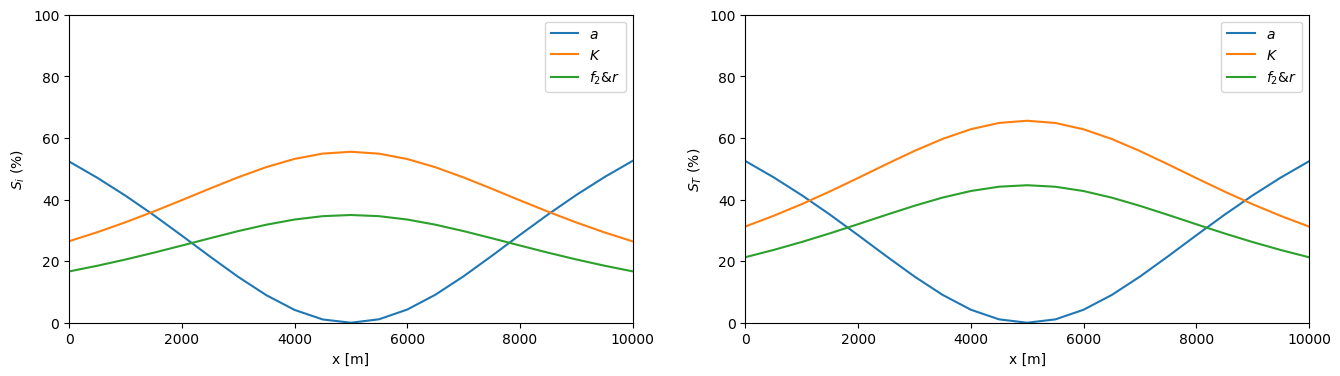

In [9]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R1G1M2[ix]['S1'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [Si_R1G1M2[ix]['S1'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [(Si_R1G1M2[ix]['S1'][2] + Si_R1G1M2[ix]['S1'][3] + Si_R1G1M2[ix]['S2'][2, 3]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R1G1M2[ix]['ST'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [Si_R1G1M2[ix]['ST'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [(Si_R1G1M2[ix]['ST'][2] + Si_R1G1M2[ix]['ST'][3]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R1G2M1

In [10]:
# Define the model inputs
problem = {'num_vars': 4,
           'names': ['a', 'k1', 'k2', 'f1'],
           'bounds': [bounds['a'], bounds['k1'], bounds['k2'], bounds['f1']],
           'dists': [dists['a'], dists['k1'], dists['k2'], dists['f1']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R1(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 2]
h2 = model_M1(param_values[:, 3])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R1G2M1 = {}     
Si_R1G2M1 = {}
for ix, x in zip(range(Nx), X):
    q_R1G2M1[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    if ix == qid:
        print('Parameter sensitivity at x=7000m: \n')
        Si_R1G2M1[ix] = sobol.analyze(problem, q_R1G2M1[ix], print_to_console=True, calc_second_order=True)
    else:
        Si_R1G2M1[ix] = sobol.analyze(problem, q_R1G2M1[ix], print_to_console=False, calc_second_order=True)

Parameter sensitivity at x=7000m: 

Parameter S1 S1_conf ST ST_conf
a 0.334328 0.015860 0.340808 0.010748
k1 0.003681 0.005655 0.041165 0.002565
k2 0.105582 0.009702 0.116591 0.004817
f1 0.514792 0.023123 0.546482 0.016712

Parameter_1 Parameter_2 S2 S2_conf
a k1 0.003312 0.020830
a k2 0.003081 0.022163
a f1 0.001454 0.025960
k1 k2 0.004241 0.009399
k1 f1 0.030450 0.010060
k2 f1 0.001209 0.017425


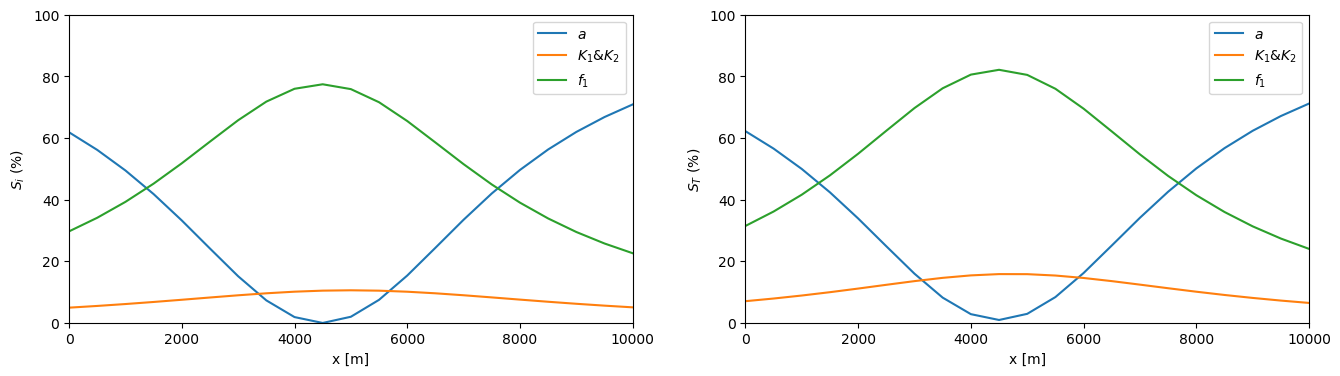

In [11]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R1G2M1[ix]['S1'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R1G2M1[ix]['S1'][1] + Si_R1G1M2[ix]['S1'][2] + Si_R1G1M2[ix]['S2'][1, 2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [Si_R1G2M1[ix]['S1'][3]  * 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R1G2M1[ix]['ST'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R1G2M1[ix]['ST'][1] + Si_R1G1M2[ix]['ST'][2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [Si_R1G2M1[ix]['ST'][3] * 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R1G2M2

In [12]:
# Define the model inputs
problem = {'num_vars': 5,
           'names': ['a', 'k1', 'k2', 'f2', 'r'],
           'bounds': [bounds['a'], bounds['k1'], bounds['k2'], bounds['f2'], bounds['r']],
           'dists': [dists['a'], dists['k1'], dists['k2'], dists['f2'], dists['r']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R1(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 2]
h2 = model_M2(param_values[:, 3], param_values[:, 4])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R1G2M2 = {}     
Si_R1G2M2 = {}
for ix, x in zip(range(Nx), X):
    q_R1G2M2[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    if ix == qid:
        print('Parameter sensitivity at x=7000m: \n')
        Si_R1G2M2[ix] = sobol.analyze(problem, q_R1G2M2[ix], print_to_console=True, calc_second_order=True)
    else:
        Si_R1G2M2[ix] = sobol.analyze(problem, q_R1G2M2[ix], print_to_console=False, calc_second_order=True)

Parameter sensitivity at x=7000m: 

Parameter S1 S1_conf ST ST_conf
a 0.351955 0.018279 0.358267 0.011512
k1 0.322686 0.019448 0.341201 0.012090
k2 0.041129 0.006286 0.045361 0.001804
f2 0.057034 0.007440 0.060422 0.002175
r 0.206249 0.012994 0.219315 0.006822

Parameter_1 Parameter_2 S2 S2_conf
a k1 0.003799 0.024630
a k2 0.003120 0.023366
a f2 -0.000457 0.024336
a r 0.000197 0.026732
k1 k2 -0.000217 0.026351
k1 f2 0.002650 0.027448
k1 r 0.011222 0.030332
k2 f2 -0.000771 0.008547
k2 r 0.000194 0.009120
f2 r 0.000254 0.012076


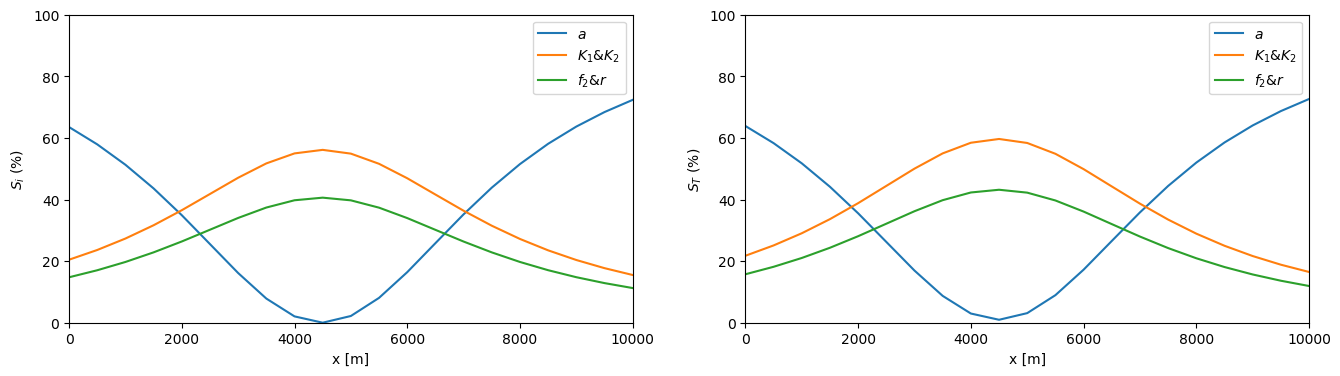

In [13]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R1G2M2[ix]['S1'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R1G2M2[ix]['S1'][1] + Si_R1G2M2[ix]['S1'][2] + Si_R1G2M2[ix]['S2'][1, 2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [(Si_R1G2M2[ix]['S1'][3] + Si_R1G2M2[ix]['S1'][4] + Si_R1G2M2[ix]['S2'][3, 4])  * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R1G2M2[ix]['ST'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R1G2M2[ix]['ST'][1] + Si_R1G2M2[ix]['ST'][2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [(Si_R1G2M2[ix]['ST'][3] + Si_R1G2M2[ix]['ST'][4]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R2G1M1

In [14]:
# Define the model inputs
problem = {'num_vars': 3,
           'names': ['b', 'hk', 'f1'],
            'bounds': [bounds['b'], bounds['hk'], bounds['f1']],
           'dists': [dists['b'], dists['hk'], dists['f1']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R2(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 1]
h2 = model_M1(param_values[:, 2])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R2G1M1 = {}     
Si_R2G1M1 = {}
for ix, x in zip(range(Nx), X):
    q_R2G1M1[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    if ix == qid:
        print('Parameter sensitivity at x=7000m: \n')
        Si_R2G1M1[ix] = sobol.analyze(problem, q_R2G1M1[ix], print_to_console=True, calc_second_order=True)
    else:
        Si_R2G1M1[ix] = sobol.analyze(problem, q_R2G1M1[ix], print_to_console=False, calc_second_order=True)

Parameter sensitivity at x=7000m: 

Parameter S1 S1_conf ST ST_conf
b 0.220360 0.013358 0.220302 0.010240
hk 0.200015 0.022370 0.328234 0.021110
f1 0.452273 0.025135 0.588007 0.029664

Parameter_1 Parameter_2 S2 S2_conf
b hk 0.000569 0.020212
b f1 -0.000530 0.018055
hk f1 0.123150 0.049587


In [107]:
# Variance decomposition for this model
print('Variance is %.4f' %np.var(q_R2G1M1[qid]))
print('V_R\tV_RG\tV_RM\tV_RGM\tV_TR\tS_R\tS_TR')
print('%.4f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R2G1M1[qid]['S1'][0] * np.var(q_R2G1M1[qid]), 0, 0, 0, Si_R2G1M1[qid]['ST'][0] * np.var(q_R2G1M1[qid]), Si_R2G1M1[qid]['S1'][0] * 100, Si_R2G1M1[qid]['ST'][0] * 100))
print('V_G\tV_RG\tV_GM\tV_RGM\tV_TG\tS_G\tS_TG')
print('%.4f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R2G1M1[qid]['S1'][1] * np.var(q_R2G1M1[qid]), 0, Si_R2G1M1[qid]['S2'][1, 2], 0, Si_R2G1M1[qid]['ST'][0] * np.var(q_R2G1M1[qid]), Si_R2G1M1[qid]['S1'][1] * 100, Si_R2G1M1[qid]['ST'][1] * 100))
print('V_M\tV_RM\tV_GM\tV_RGM\tV_TM\tS_M\tS_TM')
print('%.4f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R2G1M1[qid]['S1'][2] * np.var(q_R2G1M1[qid]), 0, Si_R2G1M1[qid]['S2'][1, 2], 0, Si_R2G1M1[qid]['ST'][0] * np.var(q_R2G1M1[qid]), Si_R2G1M1[qid]['S1'][2] * 100, Si_R2G1M1[qid]['ST'][2] * 100))


Variance is 1.2921
V_R	V_RG	V_RM	V_RGM	V_TR	S_R	S_TR
0.2847	0.00	0.00	0.00	0.28	22.04	22.03
V_G	V_RG	V_GM	V_RGM	V_TG	S_G	S_TG
0.2584	0.00	0.12	0.00	0.28	20.00	32.82
V_M	V_RM	V_GM	V_RGM	V_TM	S_M	S_TM
0.5844	0.00	0.12	0.00	0.28	45.23	58.80


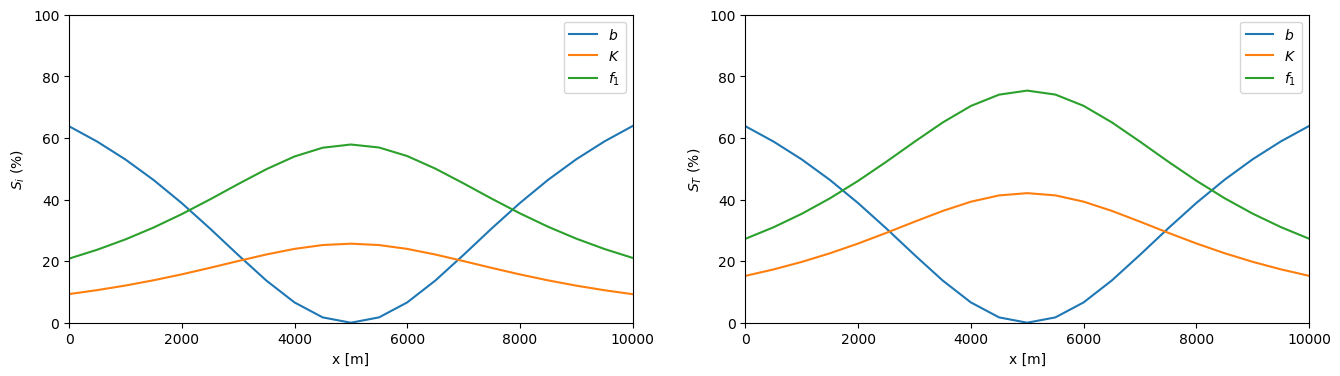

In [16]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R2G1M1[ix]['S1'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [Si_R2G1M1[ix]['S1'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [Si_R2G1M1[ix]['S1'][2]* 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R2G1M1[ix]['ST'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [Si_R2G1M1[ix]['ST'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [Si_R2G1M1[ix]['ST'][2]* 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R2G1M2

In [17]:
# Define the model inputs
problem = {'num_vars': 4,
           'names': ['b', 'hk', 'f2', 'r'],
           'bounds': [bounds['b'], bounds['hk'], bounds['f2'], bounds['r']],
           'dists': [dists['b'], dists['hk'], dists['f2'], dists['r']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R2(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 1]
h2 = model_M2(param_values[:, 2], param_values[:, 3])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R2G1M2 = {}     
Si_R2G1M2 = {}
for ix, x in zip(range(Nx), X):
    q_R2G1M2[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    Si_R2G1M2[ix] = sobol.analyze(problem, q_R2G1M2[ix], print_to_console=False, calc_second_order=True)

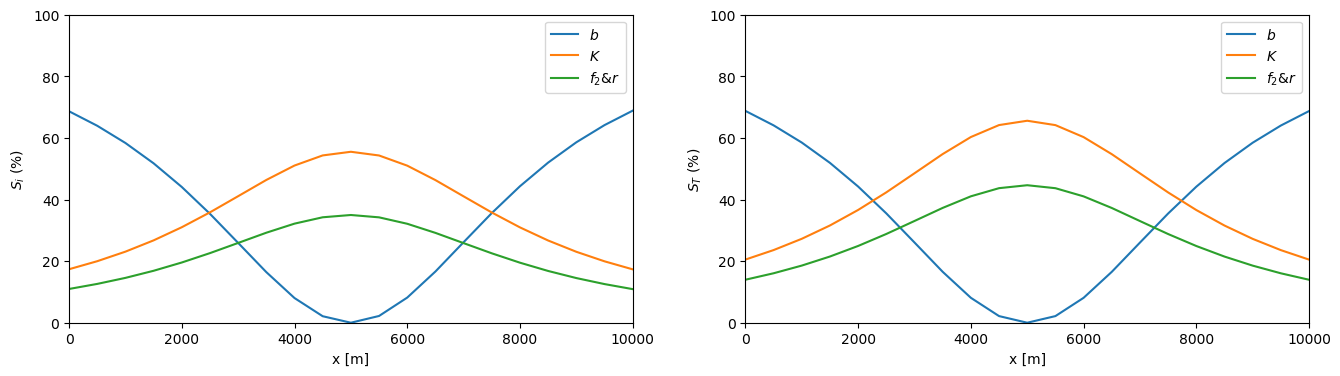

In [18]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R2G1M2[ix]['S1'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [Si_R2G1M2[ix]['S1'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [(Si_R2G1M2[ix]['S1'][2] + Si_R2G1M2[ix]['S1'][3] + Si_R2G1M2[ix]['S2'][2, 3]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R2G1M2[ix]['ST'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [Si_R2G1M2[ix]['ST'][1] * 100 for ix in range(Nx)], label='$K$')
plt.plot(X, [(Si_R2G1M2[ix]['ST'][2] + Si_R2G1M2[ix]['ST'][3]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R2G2M1

In [19]:
# Define the model inputs
problem = {'num_vars': 4,
           'names': ['b', 'k1', 'k2', 'f1'],
           'bounds': [bounds['b'], bounds['k1'], bounds['k2'], bounds['f1']],
           'dists': [dists['b'], dists['k1'], dists['k2'], dists['f1']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R2(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 2]
h2 = model_M1(param_values[:, 3])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R2G2M1 = {}     
Si_R2G2M1 = {}
for ix, x in zip(range(Nx), X):
    q_R2G2M1[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    Si_R2G2M1[ix] = sobol.analyze(problem, q_R2G2M1[ix], print_to_console=False, calc_second_order=True)

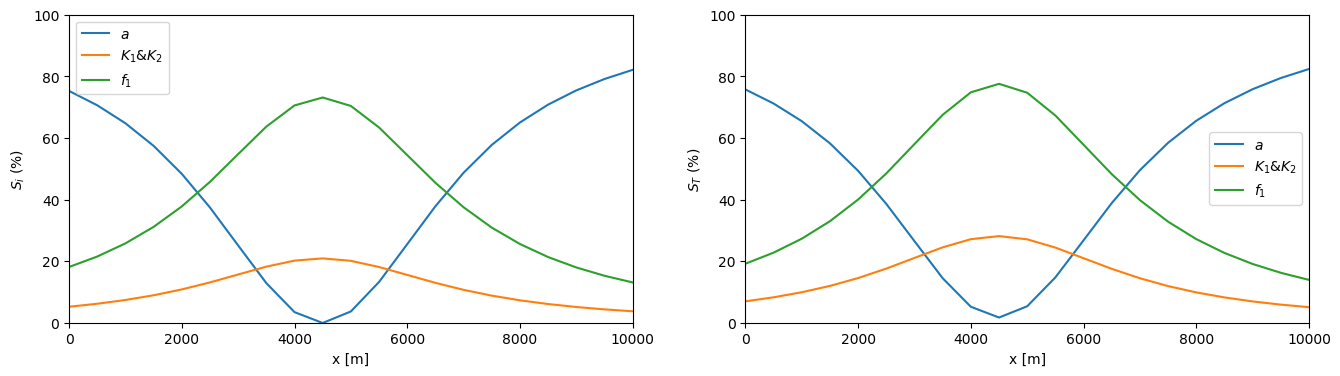

In [20]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R2G2M1[ix]['S1'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R2G2M1[ix]['S1'][1] + Si_R2G2M1[ix]['S1'][2] + Si_R2G2M1[ix]['S2'][1, 2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [Si_R2G2M1[ix]['S1'][3]  * 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R2G2M1[ix]['ST'][0] * 100 for ix in range(Nx)], label='$a$')
plt.plot(X, [(Si_R2G2M1[ix]['ST'][1] + Si_R2G2M1[ix]['ST'][2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [Si_R2G2M1[ix]['ST'][3] * 100 for ix in range(Nx)], label='$f_1$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

### MODEL: R2G2M2

In [21]:
# Define the model inputs
problem = {'num_vars': 5,
           'names': ['b', 'k1', 'k2', 'f2', 'r'],
           'bounds': [bounds['b'], bounds['k1'], bounds['k2'], bounds['f2'], bounds['r']],
           'dists': [dists['b'], dists['k1'], dists['k2'], dists['f2'], dists['r']]
           }

# Generate samples
param_values = saltelli.sample(problem, 10000, calc_second_order=True)

w = model_R2(param_values[:, 0])
k1 = param_values[:, 1]
k2 = param_values[:, 2]
h2 = model_M2(param_values[:, 3], param_values[:, 4])
    
# Evalauate model and perform sensitivity analysis at given locations
q_R2G2M2 = {}     
Si_R2G2M2 = {}
for ix, x in zip(range(Nx), X):
    q_R2G2M2[ix] = analytical_dsc_solver(w, k1, k2, h2, x)
    Si_R2G2M2[ix] = sobol.analyze(problem, q_R2G2M2[ix], print_to_console=False, calc_second_order=True)

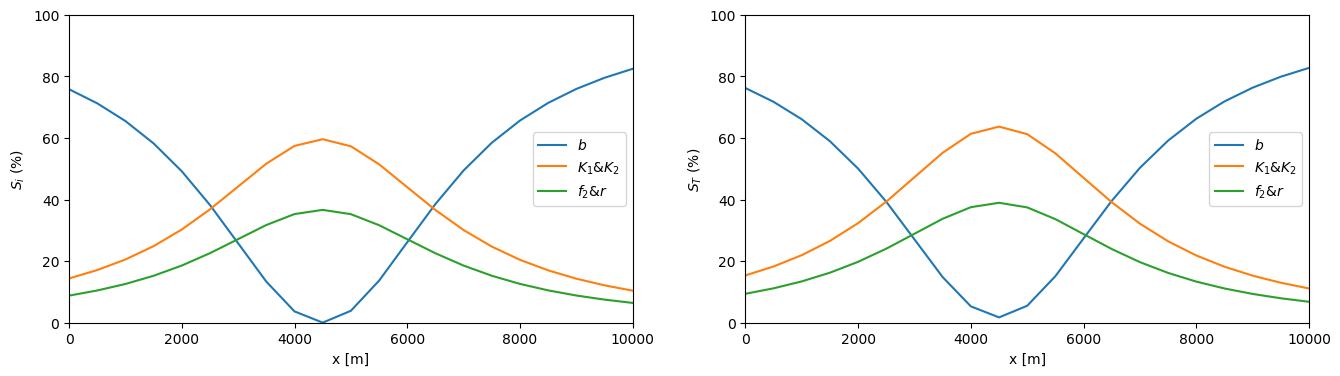

In [22]:
# Show the spital distributions of the parameter sensitivity
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(X, [Si_R2G2M2[ix]['S1'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [(Si_R2G2M2[ix]['S1'][1] + Si_R2G2M2[ix]['S1'][2] + Si_R2G2M2[ix]['S2'][1, 2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [(Si_R2G2M2[ix]['S1'][3] + Si_R2G2M2[ix]['S1'][4] + Si_R2G2M2[ix]['S2'][3, 4])  * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_i$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, [Si_R2G2M2[ix]['ST'][0] * 100 for ix in range(Nx)], label='$b$')
plt.plot(X, [(Si_R2G2M2[ix]['ST'][1] + Si_R2G2M2[ix]['ST'][2]) * 100 for ix in range(Nx)], label='$K_1&K_2$')
plt.plot(X, [(Si_R2G2M2[ix]['ST'][3] + Si_R2G2M2[ix]['ST'][4]) * 100 for ix in range(Nx)], label='$f_2&r$')
plt.xlabel('x [m]')
plt.ylabel('$S_T$' + ' (%)')
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend()

plt.show()

## Process sensitivity considering both model uncertainty and parametric uncertainty


### Compute discharge per unit width under multi-model 

In [23]:
# Model information            
N = 300                # Number of samples generated for each  parameter
Ma = 2                 # Number of alterantive models for recharge process
Mb = 2                 # Number of alterantive models for geloogy process
Mc = 2                 # Number of alterantive models for snow melt process

# Generate parameters using SALib.sample.saltelli
problem = {'num_vars': 8,
           'names': ['a', 'b', 'hk', 'k1', 'k2', 'f1', 'f2', 'r'],
           'bounds': [bounds['a'], bounds['b'], bounds['hk'], bounds['k1'], bounds['k2'], bounds['f1'], bounds['f2'], bounds['r']],
           'dists': [dists['a'], dists['b'], dists['hk'], dists['k1'], dists['k2'], dists['f1'], dists['f2'], dists['r']]
           }

param_values = saltelli.sample(problem, N, calc_second_order=False, seed=2**30)[::10, :]

# Calculate hydraulic head using numba to accelerate
@nb.njit(parallel=True, fastmath=True)
def cmpt_Dscs():
    sims = 0
    Y = np.zeros((Nx, Ma, N, Mb, N, Mc, N), dtype=np.float32)
    for ix, x in zip(range(Nx), X):
        for i in range(Ma):
            for j in nb.prange(N):
                if i == 0:
                    a = param_values[j, 0]
                    w = a * (P - 14)**0.5 * 25.4 * 0.001 / 365
                else:
                    b = param_values[j, 1]
                    w = b * (P - 15.7) * 25.4 * 0.001 / 365

                for k in range (Mb):
                    for l in nb.prange(N):
                        if k == 0:
                            k1 = param_values[l, 2]
                            k2 = param_values[l, 2]
                        else:
                            k1 = param_values[l, 3]
                            k2 = param_values[l, 4]

                        for m in range(Mc):
                            for n in nb.prange(N):
                                if m == 0:
                                    f1 = param_values[n, 5]
                                    M = f1 * (Ta - Tm)
                                    Q = Csn * M * SVC * A * 0.001 / 86400
                                    h2 = 0.3 * Q**0.6 + z0
                                else:
                                    f2 = param_values[n, 6]
                                    r = param_values[n, 7]
                                    M = f2 * (Ta - Tm) + r * Rn
                                    Q = Csn * M * SVC * A * 0.001 / 86400
                                    h2 = 0.3 * Q**0.6 + z0

                                sims = sims + 1
                                '''
                                # If parallel computing is used, do not print info 
                                if sims % (N * Mc * N) == 0 :
                                    print('Evaluating dvds at i =', i, 'j =', j, 'k =' , k, 'l =', l, 'm =', m, 'n =', n)
                                '''
                                C1 = (h1**2 - h2**2 - w / k1 * x0**2 + w / k2 * x0**2 - w / k2 * L**2) / (k1 / k2 * x0 - k1 / k2 * L - x0)
                                Y[ix, i, j, k, l, m, n] =  w * x - k1 * C1 / 2
                            
    return Y
                
# Save hydraulic head to local disk
Y = cmpt_Dscs()
np.save('Y_GW_Model_' + str(N) + '.npy', Y)

C:\ProgramData\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


### Define first-order process sensitivit index for recharge process 

In [24]:
# @nb.jit(fastmath=True)
def SI_Process_A(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tc_d = np.zeros([Ma, N, Mb, N, Mc])
    E_c_d = np.zeros([Ma, N, Mb, N])
    E_tb_d = np.zeros([Ma, N, Mb])
    E_b_d = np.zeros([Ma, N])
    E_ta_d = np.zeros([Ma])
    E_ta_d2 = np.zeros([Ma])
     
    for i in range(Ma):      
        for j in range(N):                
            for k in range(Mb):    
                for l in range(N):                 
                    for m in range(Mc):
                        E_tc_d[i, j, k, l, m] = np.mean(Y[i, j, k, l, m, :])
                    E_c_d[i, j, k, l] = PMC[0] * E_tc_d[i, j, k, l, 0] + PMC[1] * E_tc_d[i, j, k, l, 1]
                E_tb_d[i, j, k] = np.mean(E_c_d[i, j, k, :])
            E_b_d[i, j] = PMB[0] * E_tb_d[i, j, 0] + PMB[1] * E_tb_d[i, j, 1]
        E_ta_d[i] = np.mean(E_b_d[i, :])
        E_ta_d2[i] = np.mean(E_b_d[i, :]**2)
        
    E_a_d = PMA[0] * E_ta_d[0] + PMA[1] * E_ta_d[1]
    E_a_d2 = PMA[0] * E_ta_d2[0] + PMA[1] * E_ta_d2[1]
 
    Var_A = E_a_d2 - E_a_d**2
    SI_A = Var_A / (Var_t_d)
 
    return SI_A

### Define first-order process sensitivit index for geology process 

In [25]:
# @nb.jit(fastmath=True)
def SI_Process_B(Y):
   
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tc_d = np.zeros([Mb, N, Ma, N, Mc])
    E_c_d = np.zeros([Mb, N, Ma, N])
    E_ta_d = np.zeros([Mb, N, Ma])
    E_a_d = np.zeros([Mb, N])
    E_tb_d = np.zeros([Mb])
    E_tb_d2 = np.zeros([Mb])
     
    for i in range(Mb):      
        for j in range(N):                
            for k in range(Ma):    
                for l in range(N):                 
                    for m in range(Mc):
                        E_tc_d[i, j, k, l, m] = np.mean(Y[k, l, i, j, m, :])
                    E_c_d[i, j, k, l] = PMC[0] * E_tc_d[i, j, k, l, 0] + PMC[1] * E_tc_d[i, j, k, l, 1]
                E_ta_d[i, j, k] = np.mean(E_c_d[i, j, k, :])
            E_a_d[i, j] = PMA[0] * E_ta_d[i, j, 0] + PMA[1] * E_ta_d[i, j, 1]
        E_tb_d[i] = np.mean(E_a_d[i, :])
        E_tb_d2[i] = np.mean(E_a_d[i, :]**2)
        
    E_b_d = PMB[0] * E_tb_d[0] + PMB[1] * E_tb_d[1]
    E_b_d2 = PMB[0] * E_tb_d2[0] + PMB[1] * E_tb_d2[1]

    Var_B = E_b_d2 - E_b_d**2
    SI_B = Var_B / (Var_t_d)
 
    return SI_B

### Define first-order process sensitivit index for snow melt process 

In [26]:
# @nb.jit(fastmath=True)
def SI_Process_C(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tb_d = np.zeros([Mc, N, Ma, N, Mb])
    E_b_d = np.zeros([Mc, N, Ma, N])
    E_ta_d = np.zeros([Mc, N, Ma])
    E_a_d = np.zeros([Mc, N])
    E_tc_d = np.zeros([Mc])
    E_tc_d2 = np.zeros([Mc])
     
    for i in range(Mc):      
        for j in range(N):                
            for k in range(Ma):    
                for l in range(N):                 
                    for m in range(Mb):
                        E_tb_d[i, j, k, l, m] = np.mean(Y[k, l, m, :, i, j])
                    E_b_d[i, j, k, l] = PMB[0] * E_tb_d[i, j, k, l, 0] + PMB[1] * E_tb_d[i, j, k, l, 1]
                E_ta_d[i, j, k] = np.mean(E_b_d[i, j, k, :])
            E_a_d[i, j] = PMA[0] * E_ta_d[i, j, 0] + PMA[1] * E_ta_d[i, j, 1]
        E_tc_d[i] = np.mean(E_a_d[i, :])
        E_tc_d2[i] = np.mean(E_a_d[i, :]**2)
        
    E_c_d = PMC[0] * E_tc_d[0] + PMC[1] * E_tc_d[1]
    E_c_d2 = PMC[0] * E_tc_d2[0] + PMC[1] * E_tc_d2[1]

    Var_C = E_c_d2 - E_c_d**2
    SI_C = Var_C / (Var_t_d)
 
    return SI_C

### Define total-effect process sensitivity index for recharge process

In [27]:
# @nb.jit(fastmath=True)
def ST_Process_A(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_ta_d = np.zeros([Mb, N, Mc, N, Ma])
    E_a_d = np.zeros([Mb, N, Mc, N])
    E_tc_d = np.zeros([Mb, N, Mc])
    E_tc_d2 = np.zeros([Mb, N, Mc])
    E_c_d = np.zeros([Mb, N])
    E_c_d2 = np.zeros([Mb, N])

    E_tb_d = np.zeros([Mb])
    E_tb_d2 = np.zeros([Mb])
    

    for i in range(Mb):
        for j in range(N):
            for k in range(Mc):
                for l in range(N):
                    for m in range(Ma):
                        E_ta_d[i, j, k, l, m] = np.mean(Y[m, :, i, j, k, l])
                    E_a_d[i, j, k, l] = PMA[0] * np.mean(E_ta_d[i, j, k, l, 0]) + PMA[1] * np.mean(E_ta_d[i, j, k, l, 1])
                E_tc_d[i, j, k] = np.mean(E_a_d[i, j, k, :])
                E_tc_d2[i, j, k] = np.mean(E_a_d[i, j, k, :]**2)
            E_c_d[i, j] = PMC[0] * E_tc_d[i, j, 0] + PMC[1] * E_tc_d[i, j, 1]
            E_c_d2[i, j] = PMC[0] * E_tc_d2[i, j, 0] + PMC[1] * E_tc_d2[i, j, 1]
        E_tb_d[i] = np.mean(E_c_d[i, :])
        E_tb_d2[i] = np.mean(E_tc_d2[i, :])
    E_b_d = PMB[0] * E_tb_d[0] + PMB[1] * E_tb_d[1]
    E_b_d2 = PMB[0] * E_tb_d2[0] + PMB[1] * E_tb_d2[1]
        
    Var_A = E_b_d2 - E_b_d**2
    ST_A = 1 - Var_A / (Var_t_d + 1e-20)
    
    return ST_A    

### Define total-effect process sensitivity index for geology process

In [28]:
# @nb.jit(fastmath=True)
def ST_Process_B(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tb_d = np.zeros([Ma, N, Mc, N, Mb])
    E_b_d = np.zeros([Ma, N, Mc, N])
    E_tc_d = np.zeros([Ma, N, Mc])
    E_tc_d2 = np.zeros([Ma, N, Mc])
    E_c_d = np.zeros([Ma, N])
    E_c_d2 = np.zeros([Ma, N])

    E_ta_d = np.zeros([Ma])
    E_ta_d2 = np.zeros([Ma])
    

    for i in range(Ma):
        for j in range(N):
            for k in range(Mc):
                for l in range(N):
                    for m in range(Mb):
                        E_tb_d[i, j, k, l, m] = np.mean(Y[i, j, m, :, k, l])
                    E_b_d[i, j, k, l] = PMB[0] * np.mean(E_tb_d[i, j, k, l, 0]) + PMB[1] * np.mean(E_tb_d[i, j, k, l, 1])
                E_tc_d[i, j, k] = np.mean(E_b_d[i, j, k, :])
                E_tc_d2[i, j, k] = np.mean(E_b_d[i, j, k, :]**2)
            E_c_d[i, j] = PMC[0] * E_tc_d[i, j, 0] + PMC[1] * E_tc_d[i, j, 1]
            E_c_d2[i, j] = PMC[0] * E_tc_d2[i, j, 0] + PMC[1] * E_tc_d2[i, j, 1]
        E_ta_d[i] = np.mean(E_c_d[i, :])
        E_ta_d2[i] = np.mean(E_tc_d2[i, :])
    E_a_d = PMA[0] * E_ta_d[0] + PMA[1] * E_ta_d[1]
    E_a_d2 = PMA[0] * E_ta_d2[0] + PMA[1] * E_ta_d2[1]
        
    Var_B = E_a_d2 - E_a_d**2
    ST_B = 1 - Var_B / (Var_t_d + 1e-20)
    
    return ST_B

### Define total-effect process sensitivity index for snow-melt process

In [29]:
# @nb.jit(fastmath=True)
def ST_Process_C(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tc_d = np.zeros([Ma, N, Mb, N, Mc])
    E_c_d = np.zeros([Ma, N, Mb, N])
    E_tb_d = np.zeros([Ma, N, Mb])
    E_tb_d2 = np.zeros([Ma, N, Mb])
    E_b_d = np.zeros([Ma, N])
    E_b_d2 = np.zeros([Ma, N])

    E_ta_d = np.zeros([Ma])
    E_ta_d2 = np.zeros([Ma])
    

    for i in range(Ma):
        for j in range(N):
            for k in range(Mb):
                for l in range(N):
                    for m in range(Mc):
                        E_tc_d[i, j, k, l, m] = np.mean(Y[i, j, k, l, m, :])
                    E_c_d[i, j, k, l] = PMC[0] * np.mean(E_tc_d[i, j, k, l, 0]) + PMC[1] * np.mean(E_tc_d[i, j, k, l, 1])
                E_tb_d[i, j, k] = np.mean(E_c_d[i, j, k, :])
                E_tb_d2[i, j, k] = np.mean(E_c_d[i, j, k, :]**2)
            E_b_d[i, j] = PMB[0] * E_tb_d[i, j, 0] + PMB[1] * E_tb_d[i, j, 1]
            E_b_d2[i, j] = PMB[0] * E_tb_d2[i, j, 0] + PMB[1] * E_tb_d2[i, j, 1]
        E_ta_d[i] = np.mean(E_b_d[i, :])
        E_ta_d2[i] = np.mean(E_tb_d2[i, :])
    E_a_d = PMA[0] * E_ta_d[0] + PMA[1] * E_ta_d[1]
    E_a_d2 = PMA[0] * E_ta_d2[0] + PMA[1] * E_ta_d2[1]
        
    Var_C = E_a_d2 - E_a_d**2
    ST_C = 1 - Var_C / (Var_t_d + 1e-20)
    
    return ST_C

### Compuet the process sensitivity 

In [30]:
SI_A = np.zeros(Nx)
SI_B = np.zeros(Nx)
SI_C = np.zeros(Nx)

ST_A = np.zeros(Nx)
ST_B = np.zeros(Nx)
ST_C = np.zeros(Nx)

for ix in range(Nx):
    print('Calculating process sensitivity for node', ix)
    SI_A[ix] = SI_Process_A(Y[ix, :, :, :, :])
    SI_B[ix] = SI_Process_B(Y[ix, :, :, :, :])
    SI_C[ix] = SI_Process_C(Y[ix, :, :, :, :])

    ST_A[ix] = ST_Process_A(Y[ix, :, :, :, :])
    ST_B[ix] = ST_Process_B(Y[ix, :, :, :, :])
    ST_C[ix] = ST_Process_C(Y[ix, :, :, :, :])
    

Calculating process sensitivity for node 0
Calculating process sensitivity for node 1
Calculating process sensitivity for node 2
Calculating process sensitivity for node 3
Calculating process sensitivity for node 4
Calculating process sensitivity for node 5
Calculating process sensitivity for node 6
Calculating process sensitivity for node 7
Calculating process sensitivity for node 8
Calculating process sensitivity for node 9
Calculating process sensitivity for node 10
Calculating process sensitivity for node 11
Calculating process sensitivity for node 12
Calculating process sensitivity for node 13
Calculating process sensitivity for node 14
Calculating process sensitivity for node 15
Calculating process sensitivity for node 16
Calculating process sensitivity for node 17
Calculating process sensitivity for node 18
Calculating process sensitivity for node 19
Calculating process sensitivity for node 20


## Dispaly the results at the traget location

In [31]:
print('Model\tR1G1M1\t\t\tR1G1M2\t\t\tR1G2M1\t\t\tR1G2M2')
print('Para.\ta\tk\tf1\ta\tk\tf2&r\ta\tk1&k2\tf1\ta\tk1&k2\tf2&r')
print('First\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R1G1M1[qid]['S1'][0] * 100, Si_R1G1M1[qid]['S1'][1] * 100, Si_R1G1M1[qid]['S1'][2] * 100, Si_R1G1M2[qid]['S1'][0] * 100,  Si_R1G1M2[qid]['S1'][1] * 100,  (Si_R1G1M2[qid]['S1'][2] + Si_R1G1M2[qid]['S1'][3] + Si_R1G1M2[qid]['S2'][2, 3]) * 100, Si_R1G2M1[qid]['S1'][0] * 100, (Si_R1G2M1[qid]['S1'][1] + Si_R1G2M1[qid]['S1'][2] + Si_R1G2M1[qid]['S2'][1, 2]) * 100, Si_R1G2M1[qid]['S1'][3] * 100,  Si_R1G2M2[qid]['S1'][0] * 100, (Si_R1G2M2[qid]['S1'][1] + Si_R1G2M2[qid]['S1'][2] + Si_R1G2M2[qid]['S2'][1, 2])  * 100, (Si_R1G2M2[qid]['S1'][3] + Si_R1G2M2[qid]['S1'][4] + Si_R1G2M2[qid]['S2'][3, 4]) * 100))
print('Total\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R1G1M1[qid]['ST'][0] * 100, Si_R1G1M1[qid]['ST'][1] * 100, Si_R1G1M1[qid]['ST'][2] * 100, Si_R1G1M2[qid]['ST'][0] * 100,  Si_R1G1M2[qid]['ST'][1] * 100,  (Si_R1G1M2[qid]['ST'][2] + Si_R1G1M2[qid]['ST'][3]) * 100, Si_R1G2M1[qid]['ST'][0] * 100, (Si_R1G2M1[qid]['ST'][1] + Si_R1G2M1[qid]['ST'][2]) * 100, Si_R1G2M1[qid]['ST'][3] * 100,  Si_R1G2M2[qid]['ST'][0] * 100, (Si_R1G2M2[qid]['ST'][1] + Si_R1G2M2[qid]['ST'][2])  * 100, (Si_R1G2M2[qid]['ST'][3] + Si_R1G2M2[qid]['ST'][4]) * 100))
print('Model\tR2G1M1\t\t\tR2G1M2\t\t\tR2G2M1\t\t\tR2G2M2')
print('Para.\tb\tk\tf1\tb\tk\tf2&r\tb\tk1&k2\tf1\tb\tk1&k2\tf2&r')
print('First\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R2G1M1[qid]['S1'][0] * 100, Si_R2G1M1[qid]['S1'][1] * 100, Si_R2G1M1[qid]['S1'][2] * 100, Si_R2G1M2[qid]['S1'][0] * 100,  Si_R2G1M2[qid]['S1'][1] * 100,  (Si_R2G1M2[qid]['S1'][2] + Si_R2G1M2[qid]['S1'][3] + Si_R2G1M2[qid]['S2'][2, 3]) * 100, Si_R2G2M1[qid]['S1'][0] * 100, (Si_R2G2M1[qid]['S1'][1] + Si_R2G2M1[qid]['S1'][2] + Si_R2G2M1[qid]['S2'][1, 2]) * 100, Si_R2G2M1[qid]['S1'][3] * 100,  Si_R2G2M2[qid]['S1'][0] * 100, (Si_R2G2M2[qid]['S1'][1] + Si_R2G2M2[qid]['S1'][2] + Si_R2G2M2[qid]['S2'][1, 2])  * 100, (Si_R2G2M2[qid]['S1'][3] + Si_R2G2M2[qid]['S1'][4] + Si_R2G2M2[qid]['S2'][3, 4]) * 100))
print('Total\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' %(Si_R2G1M1[qid]['ST'][0] * 100, Si_R2G1M1[qid]['ST'][1] * 100, Si_R2G1M1[qid]['ST'][2] * 100, Si_R2G1M2[qid]['ST'][0] * 100,  Si_R2G1M2[qid]['ST'][1] * 100,  (Si_R2G1M2[qid]['ST'][2] + Si_R2G1M2[qid]['ST'][3]) * 100, Si_R2G2M1[qid]['ST'][0] * 100, (Si_R2G2M1[qid]['ST'][1] + Si_R2G2M1[qid]['ST'][2]) * 100, Si_R2G2M1[qid]['ST'][3] * 100,  Si_R2G2M2[qid]['ST'][0] * 100, (Si_R2G2M2[qid]['ST'][1] + Si_R2G2M2[qid]['ST'][2])  * 100, (Si_R2G2M2[qid]['ST'][3] + Si_R2G2M2[qid]['ST'][4]) * 100))
print('\n')
print('Process\t\tRecharge\tGeology\t\tSnowmelt')
print('First\t\t%.2f\t\t%.2f\t\t%.2f' %(SI_A[qid] * 100, SI_B[qid] * 100, SI_C[qid] *100))
print('Total\t\t%.2f\t\t%.2f\t\t%.2f' %(ST_A[qid] * 100, ST_B[qid] * 100, ST_C[qid] *100))

Model	R1G1M1			R1G1M2			R1G2M1			R1G2M2
Para.	a	k	f1	a	k	f2&r	a	k1&k2	f1	a	k1&k2	f2&r
First	12.41	22.47	50.78	15.08	47.17	29.75	33.43	11.35	51.48	35.20	36.36	26.35
Total	12.37	36.87	66.06	14.98	55.74	37.95	34.08	15.78	54.65	35.83	38.66	27.97
Model	R2G1M1			R2G1M2			R2G2M1			R2G2M2
Para.	b	k	f1	b	k	f2&r	b	k1&k2	f1	b	k1&k2	f2&r
First	22.04	20.00	45.23	26.14	41.03	25.84	48.70	10.68	37.48	49.43	30.10	18.55
Total	22.03	32.82	58.80	26.02	48.49	33.01	49.55	14.43	39.79	50.30	32.16	19.67


Process		Recharge	Geology		Snowmelt
First		14.32		6.79		63.99
Total		14.67		21.68		78.54


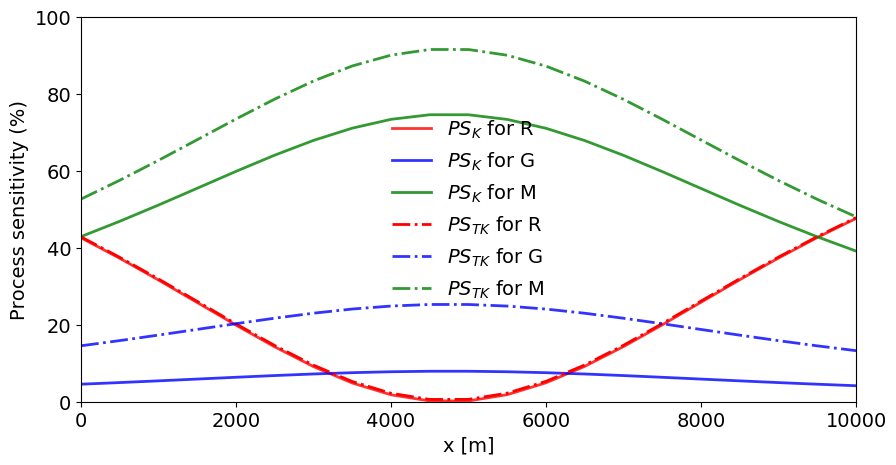

In [70]:
plt.figure(figsize=(10, 5))

plt.plot(X, SI_A * 100, label='$PS_K$' + ' for R', color='r', linestyle='-', lw=2, alpha=0.8)
plt.plot(X, SI_B * 100, label='$PS_K$' + ' for G', color='b', linestyle='-',  lw=2, alpha=0.8)
plt.plot(X, SI_C * 100, label='$PS_K$' + ' for M', color='g', linestyle='-',  lw=2, alpha=0.8)

plt.plot(X, ST_A * 100, label='$PS_{TK}$' + ' for R', color='r', linestyle='-.',  lw=2, alpha=1)
plt.plot(X, ST_B * 100, label='$PS_{TK}$' + ' for G', color='b', linestyle='-.',  lw=2, alpha=0.8)
plt.plot(X, ST_C * 100, label='$PS_{TK}$' + ' for M', color='g', linestyle='-.',  lw=2, alpha=0.8)

plt.xlabel('x [m]', fontsize=14)
plt.ylabel('Process sensitivity (%)',  fontsize=14)
plt.xlim([0, L])
plt.ylim([0, 100])
plt.legend(frameon=False, loc='center')

plt.show()

Note that for all G1 models, the interaction between the k and f1 are large. This is usually due to outputs characterised
by distributions with very long tails, whose extreme values are connected to particular combinations of factors, i.e.
the non-additive components of the model (interactions).

## Plot the 8 PDFs for groundawter discharge

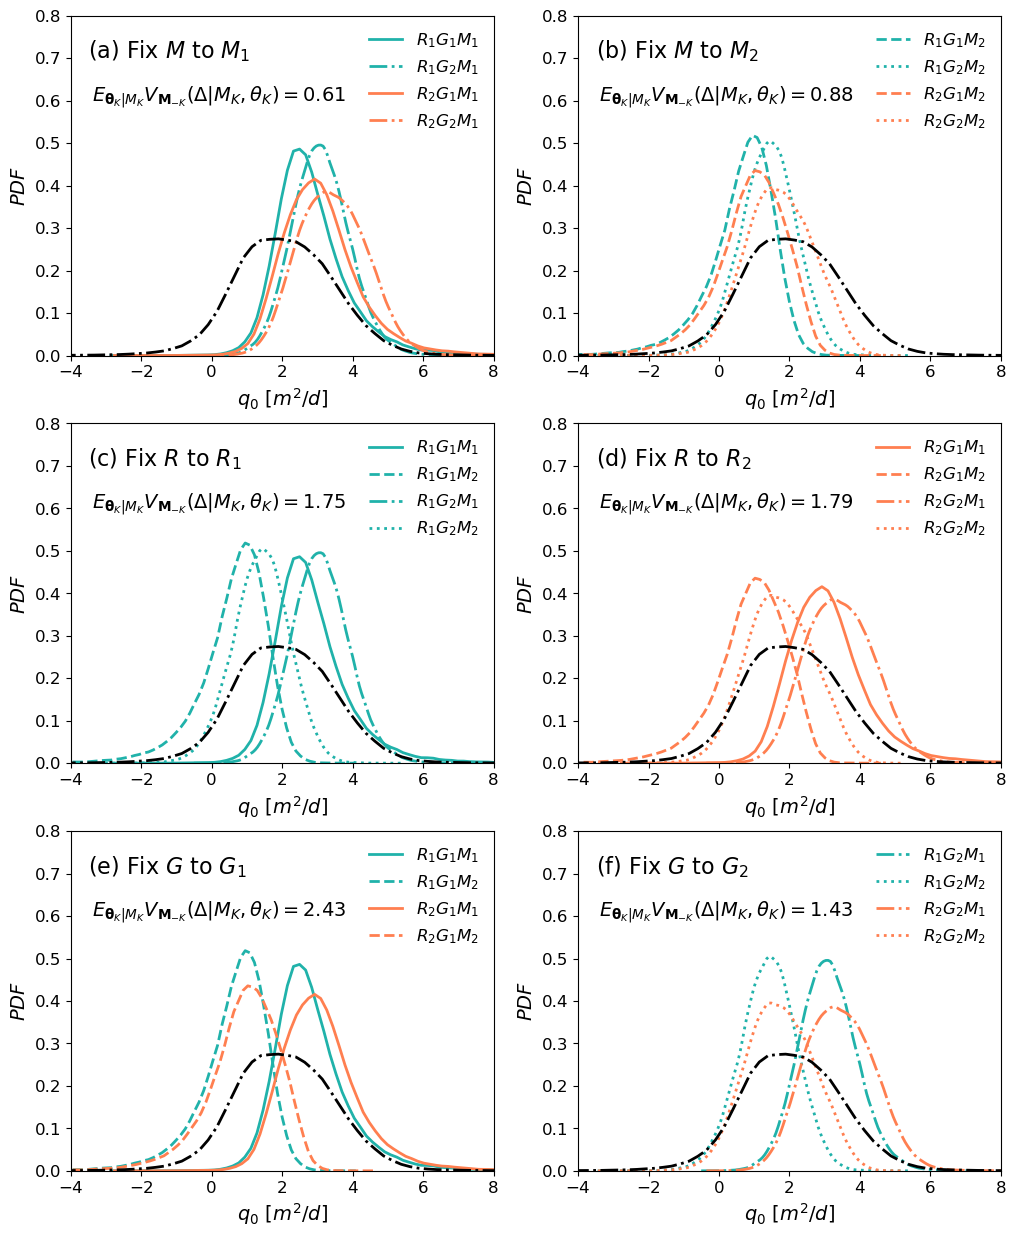

In [57]:
import matplotlib
plt.figure(figsize=(12, 15))
matplotlib.rcParams['font.size'] = 12

'''
plt.figure()
sns.kdeplot(q_R1G1M1, color= 'g', linestyle='-',  lw=2, label='R1G1M1')
sns.kdeplot(q_R1G1M2, color= 'g', linestyle='--', lw=2, label='R1G1M2')
sns.kdeplot(q_R1G2M1, color= 'g', linestyle='-.', lw=2, label='R1G2M1')
sns.kdeplot(q_R1G2M2, color= 'g', linestyle=':', lw=2, label='R1G2M2')
sns.kdeplot(q_R2G1M1, color= 'r', linestyle='-', lw=2, label='R2G1M1')
sns.kdeplot(q_R2G1M2, color= 'r', linestyle='--', lw=2, label='R2G1M2')
sns.kdeplot(q_R2G2M1, color= 'r', linestyle='-.', lw=2, label='R2G2M1')
sns.kdeplot(q_R2G2M2, color= 'r', linestyle=':', lw=2, label='R2G2M2')
# sns.kdeplot(np.reshape(Y, Ma * N * Mb * N * Mc * N), color= 'k', linestyle='-', lw=2, label='$\delta$')
plt.xlim([-4, 7])
plt.ylim([0, 0.8])
plt.show()
'''

plt.subplot(3, 2, 1)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2, label='$R_1G_1M_1$')
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2, label='$R_1G_2M_1$')
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2,  label='$R_2G_1M_1$')
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2,  label='$R_2G_2M_1$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(a) Fix ' + '$M$' + ' to ' + '$M_1$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, :, :, :, :, 0, i]) for i in range(N)])), fontsize=14)


plt.subplot(3, 2, 2)
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2, label='$R_1G_1M_2$')
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2, label='$R_1G_2M_2$')
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2,  label='$R_2G_1M_2$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2,  label='$R_2G_2M_2$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(b) Fix ' + '$M$' + ' to ' + '$M_2$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, :, :, :, :, 1, i]) for i in range(N)])), fontsize=14)

plt.subplot(3, 2, 3)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2, label='$R_1G_1M_1$')
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2, label='$R_1G_1M_2$')
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2,  label='$R_1G_2M_1$')
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2,  label='$R_1G_2M_2$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(c) Fix ' + '$R$' + ' to ' + '$R_1$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, 0, i, :, :, :, :]) for i in range(N)])), fontsize=14)


plt.subplot(3, 2, 4)
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2, label='$R_2G_1M_1$')
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2, label='$R_2G_1M_2$')
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2,  label='$R_2G_2M_1$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2,  label='$R_2G_2M_2$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(d) Fix ' + '$R$' + ' to ' + '$R_2$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, 1, i, :, :, :, :]) for i in range(N)])), fontsize=14)


plt.subplot(3, 2, 5)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2, label='$R_1G_1M_1$')
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2, label='$R_1G_1M_2$')
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2,  label='$R_2G_1M_1$')
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2,  label='$R_2G_1M_2$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(e) Fix ' + '$G$' + ' to ' + '$G_1$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, :, :, 0, i, :, :]) for i in range(N)])), fontsize=14)


plt.subplot(3, 2, 6)
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2, label='$R_1G_2M_1$')
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2, label='$R_1G_2M_2$')
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2,  label='$R_2G_2M_1$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2,  label='$R_2G_2M_2$')
sns.kdeplot(np.hstack([q_R1G1M1[qid], q_R1G1M2[qid], q_R1G2M1[qid], q_R1G2M2[qid], q_R2G1M1[qid], q_R2G1M2[qid], q_R2G2M1[qid], q_R2G2M2[qid]]), color= 'k', linestyle='-.', lw=2)
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=12)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=14)
plt.ylabel('$PDF$', fontsize=14)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(f) Fix ' + '$G$' + ' to ' + '$G_2$', fontsize=16)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_K|M_{K}}V_{{\bfM}_{-K}}(\Delta|M_K,\theta_K)= %.2f$' %(np.mean([np.var(Y[qid, :, :, 1, i, :, :]) for i in range(N)])), fontsize=14)


plt.show()


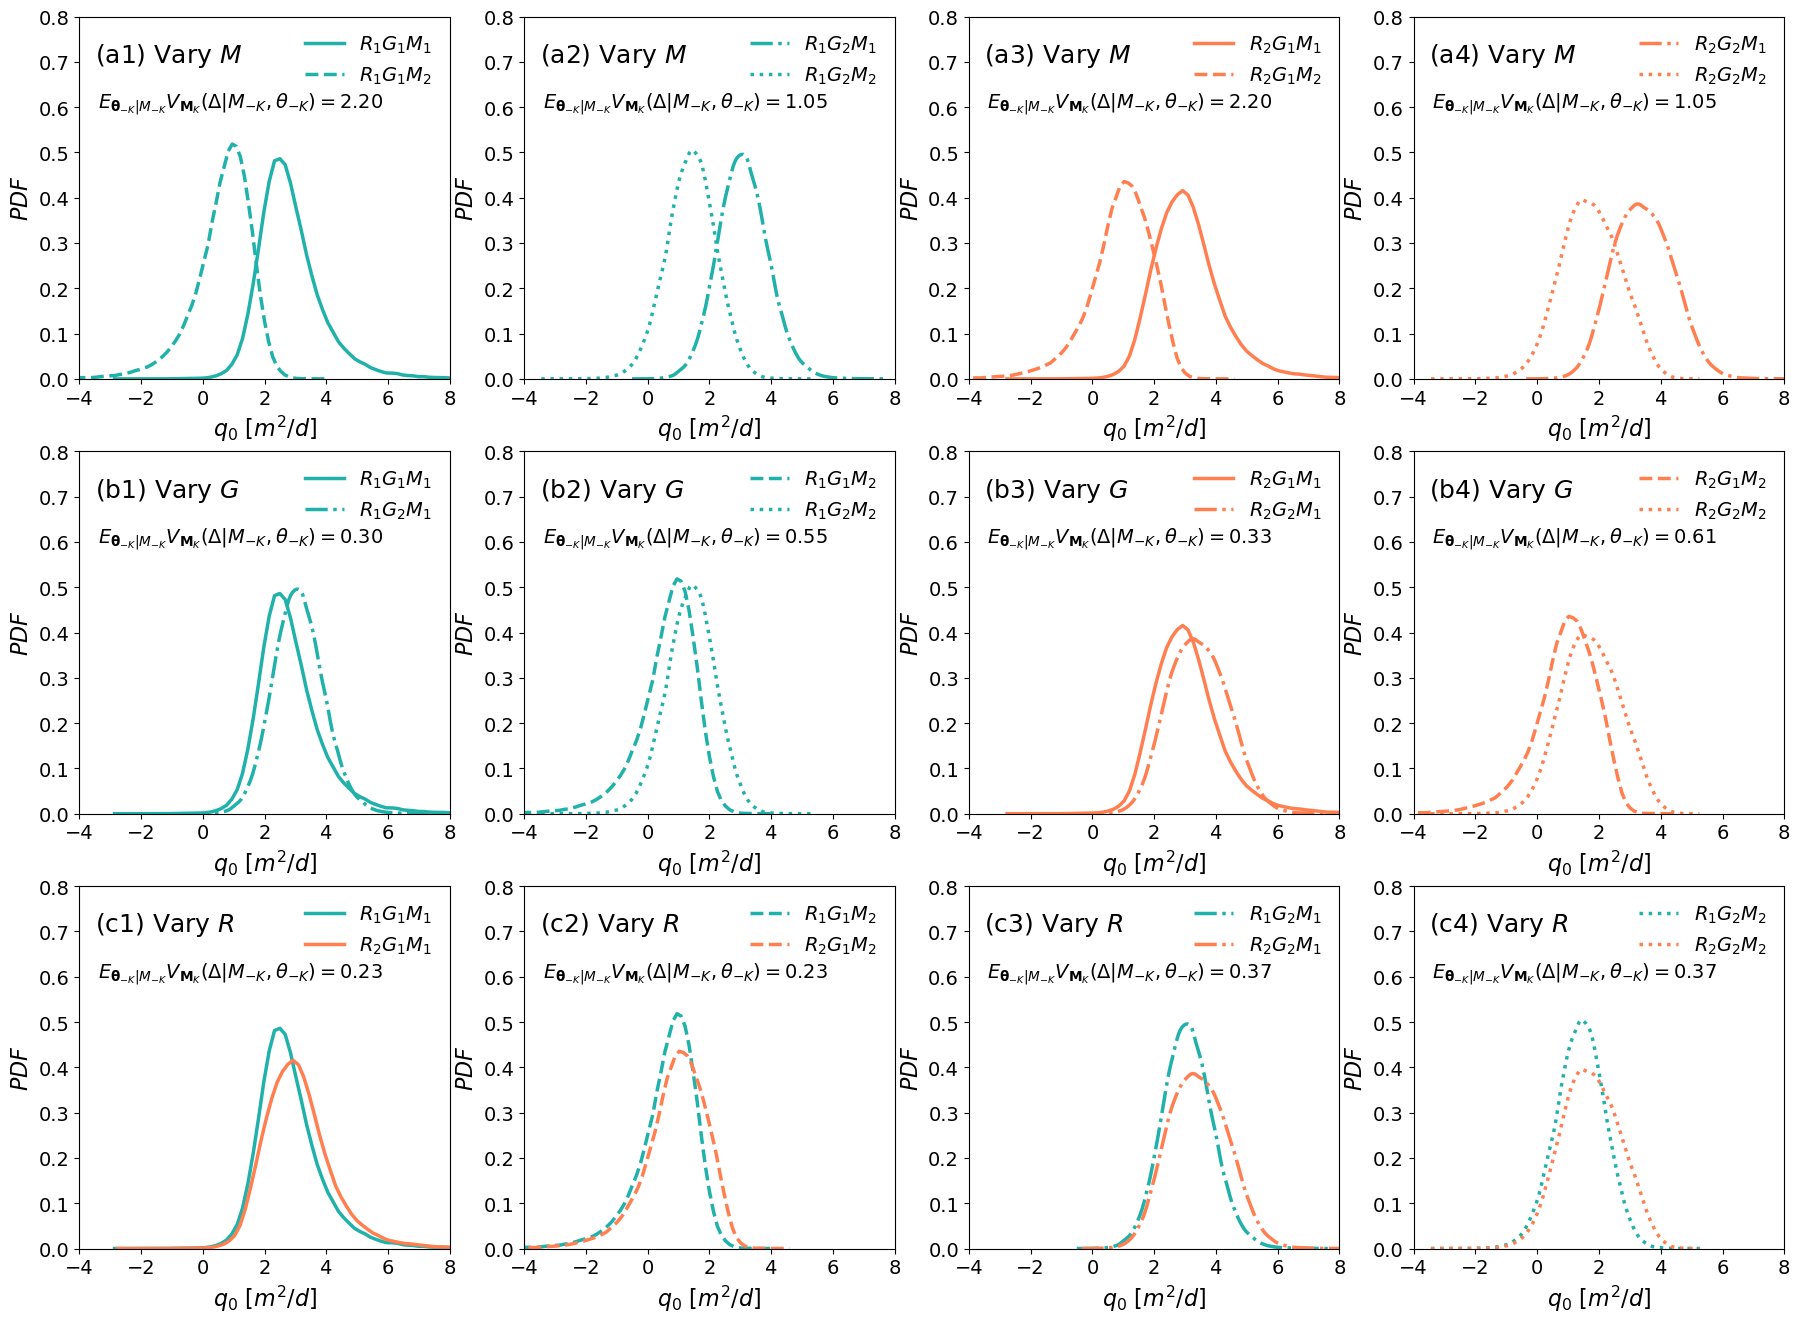

In [61]:
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(22, 16))
plt.subplot(3, 4, 1)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2.5, label='$R_1G_1M_1$')
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2.5, label='$R_1G_1M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(a1) Vary ' + '$M$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 0, i, 0, j, :, :]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 2)
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2.5,  label='$R_1G_2M_1$')
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2.5, label='$R_1G_2M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(a2) Vary ' + '$M$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 0, i, 1, j, :, :]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 3)
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2.5,  label='$R_2G_1M_1$')
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2.5,  label='$R_2G_1M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(a3) Vary ' + '$M$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 1, i, 0, j, :, :]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 4)
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2.5,  label='$R_2G_2M_1$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2.5,  label='$R_2G_2M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(a4) Vary ' + '$M$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 1, i, 1, j, :, :]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 5)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2.5, label='$R_1G_1M_1$')
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2.5, label='$R_1G_2M_1$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(b1) Vary ' + '$G$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 0, i, :, :, 0, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 6)
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2.5, label='$R_1G_1M_2$')
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2.5, label='$R_1G_2M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(b2) Vary ' + '$G$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 0, i, :, :, 1, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 7)
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2.5,  label='$R_2G_1M_1$')
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2.5,  label='$R_2G_2M_1$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(b3) Vary ' + '$G$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 1, i, :, :, 0, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 8)
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2.5,  label='$R_2G_1M_2$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2.5,  label='$R_2G_2M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(b4) Vary ' + '$G$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, 1, i, :, :, 1, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 9)
sns.kdeplot(q_R1G1M1[qid], color= 'lightseagreen', linestyle='-', lw=2.5, label='$R_1G_1M_1$')
sns.kdeplot(q_R2G1M1[qid], color= 'coral', linestyle='-', lw=2.5,  label='$R_2G_1M_1$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(c1) Vary ' + '$R$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, :, :, 0, i, 0, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 10)
sns.kdeplot(q_R1G1M2[qid], color= 'lightseagreen', linestyle='--', lw=2.5, label='$R_1G_1M_2$')
sns.kdeplot(q_R2G1M2[qid], color= 'coral', linestyle='--', lw=2.5,  label='$R_2G_1M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(c2) Vary ' + '$R$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, :, :, 0, i, 1, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 11)
sns.kdeplot(q_R1G2M1[qid], color= 'lightseagreen', linestyle='-.', lw=2.5, label='$R_1G_2M_1$')
sns.kdeplot(q_R2G2M1[qid], color= 'coral', linestyle='-.', lw=2.5,  label='$R_2G_2M_1$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(c3) Vary ' + '$R$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, :, :, 1, i, 0, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.subplot(3, 4, 12)
sns.kdeplot(q_R1G2M2[qid], color= 'lightseagreen', linestyle=':', lw=2.5, label='$R_1G_2M_2$')
sns.kdeplot(q_R2G2M2[qid], color= 'coral', linestyle=':', lw=2.5,  label='$R_2G_2M_2$')
plt.xlim([-4, 8])
plt.ylim([0, 0.8])
plt.tick_params(labelsize=14)
plt.xlabel('$q_0$' + ' $[m^2/d]$', fontsize=16)
plt.ylabel('$PDF$', fontsize=16)
plt.legend(frameon=False)
plt.text(-3.5, 0.7, '(c4) Vary ' + '$R$', fontsize=18)
plt.text(-3.4, 0.60, r'$E_{{\bf\theta}_{-K}|M_{-K}}V_{{\bfM}_{K}}(\Delta|M_{-K},\theta_{-K})= %.2f$' %(np.mean([np.var(Y[qid, :, :, 1, i, 1, j]) for i in range(N) for j in range(N)])), fontsize=14)


plt.show()


## Within- and between- model variacne left

In [71]:
# Global parameter settings
nx = 21
L = 10000
x = np.linspace(0, L, nx, endpoint=True)
N = 300
Ma, Mb, Mc = 2, 2, 2
PMA = np.array([0.5, 0.5])
PMB = np.array([0.5, 0.5])
PMC = np.array([0.5, 0.5])

def ANOVA_Var_Left_Process_A(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var = np.var(Y) 
    
    # Analysis of variance for process A
    V_t_a = np.zeros([Mb, Mc, N, N, Ma])
    V_a = np.zeros([Ma, Mb, N, N])
    V_t_c = np.zeros([Ma, Mb])
    V_c = np.zeros(Ma)
    
    # The first item: witinin-model variance left
    for k in range(Mb):
        for m in range(Mc):
            for l in range(N):
                for n in range (N):
                    for i in range(Ma):
                        V_t_a[k, m, l, n, i] = np.var(Y[i, :, k, l, m, n])
                    V_a[k, m, l, n] = np.sum(PMA * V_t_a[k, m, l, n, :])
            V_t_c[k, m] = np.mean(V_a[k, m, :, :])
        V_c[k] = np.sum(PMC * V_t_c[k, :])
    V_b = np.sum(PMB * V_c)
    
    # The second item: between-model variance left
    E_t_a = np.zeros([Mb, Mc, N, N, Ma])
    E_a = np.zeros([Mb, Mc, N, N])
    E_t_a2 = np.zeros([Mb, Mc, N, N, Ma])
    E_a2 = np.zeros([Mb, Mc, N, N])
    E_t_c2 = np.zeros([Mb, Mc])
    E_c2 = np.zeros(Mb)
    
    for k in range(Mb):
        for m in range(Mc): 
            for l in range(N):
                for n in range (N):
                    for i in range(Ma):
                        E_t_a[k, m, l, n, i] = np.mean(Y[i, :, k, l, m, n])
                    E_a[k, m, l, n] = np.sum(PMA * E_t_a[k, m, l, n, :])
                    for i in range(Ma):    
                        E_t_a2[k, m, l, n, i] = (np.mean(Y[i, :, k, l, m, n]) - E_a[k, m, l, n])**2
                    E_a2[k, m, l, n] = np.sum(PMA * E_t_a2[k, m, l, n, :])
            E_t_c2[k, m] = np.mean(E_a2[k, m, :, :]) 
        E_c2[k] = np.sum(PMC * E_t_c2[k, :])
    E_b2 = np.sum(PMB * E_c2)

    # Compute the total process sensitivity
    ST_A = (V_b + E_b2) / Var
    # print(ST_A)
    
    return V_b, E_b2
    
def ANOVA_Var_Left_Process_B(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var = np.var(Y) 
    
    # Analysis of variance for process B
    V_t_b = np.zeros([Ma, Mc, N, N, Mb])
    V_b = np.zeros([Ma, Mc, N, N])
    V_t_c = np.zeros([Ma, Mc])
    V_c = np.zeros(Ma)
    
    # The first item: witinin-model variance left
    for i in range(Ma):
        for m in range(Mc):
            for j in range(N):
                for n in range (N):
                    for k in range(Mb):
                        V_t_b[i, m, j, n, k] = np.var(Y[i, j, k, :, m, n])
                    V_b[i, m, j, n] = np.sum(PMB * V_t_b[i, m, j, n, :])
            V_t_c[i, m] = np.mean(V_b[i, m, :, :])
        V_c[i] = np.sum(PMC * V_t_c[i, :])
    V_a = np.sum(PMA * V_c)
    
    # The second item: between-model variance left
    E_t_b = np.zeros([Ma, Mc, N, N, Mb])
    E_b = np.zeros([Ma, Mc, N, N])
    E_t_b2 = np.zeros([Ma, Mc, N, N, Mb])
    E_b2 = np.zeros([Ma, Mc, N, N])
    E_t_c2 = np.zeros([Ma, Mc])
    E_c2 = np.zeros(Ma)
    
    for i in range(Ma):
        for m in range(Mc): 
            for j in range(N):
                for n in range (N):
                    for k in range(Mb):
                        E_t_b[i, m, j, n, k] = np.mean(Y[i, j, k, :, m, n])
                    E_b[i, m, j, n] = np.sum(PMB * E_t_b[i, m, j, n, :])
                    for k in range(Mb):    
                        E_t_b2[i, m, j, n, k] = (np.mean(Y[i, j, k, :, m, n]) - E_b[i, m, j, n])**2
                    E_b2[i, m, j, n] = np.sum(PMB * E_t_b2[i, m, j, n, :])
            E_t_c2[i, m] = np.mean(E_b2[i, m, :, :]) 
        E_c2[i] = np.sum(PMC * E_t_c2[i, :])
    E_a2 = np.sum(PMA * E_c2)

    # Compute the total process sensitivity
    ST_B = (V_a + E_a2) / Var
    # print(ST_B)
    return V_a, E_a2

def ANOVA_Var_Left_Process_C(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var = np.var(Y) 
    
    # Analysis of variance for process B
    V_t_c = np.zeros([Ma, Mb, N, N, Mc])
    V_c = np.zeros([Ma, Mb, N, N])
    V_t_b = np.zeros([Ma, Mb])
    V_b = np.zeros(Ma)
    
    # The first item: witinin-model variance left
    for i in range(Ma):
        for k in range(Mb):
            for j in range(N):
                for l in range (N):
                    for m in range(Mc):
                        V_t_c[i, k, j, l, m] = np.var(Y[i, j, k, l, m, :])
                    V_c[i, k, j, l] = np.sum(PMC * V_t_c[i, k, j, l, :])
            V_t_b[i, k] = np.mean(V_c[i, k, :, :])
        V_b[i] = np.sum(PMB * V_t_b[i, :])
    V_a = np.sum(PMB * V_b)
    
    # The second item: between-model variance left
    E_t_c = np.zeros([Ma, Mb, N, N, Mc])
    E_c = np.zeros([Ma, Mb, N, N])
    E_t_c2 = np.zeros([Ma, Mb, N, N, Mc])
    E_c2 = np.zeros([Ma, Mb, N, N])
    E_t_b2 = np.zeros([Ma, Mb])
    E_b2 = np.zeros(Ma)
    
    for i in range(Ma):
        for k in range(Mb): 
            for j in range(N):
                for l in range (N):
                    for m in range(Mc):
                        E_t_c[i, k, j, l, m] = np.mean(Y[i, j, k, l, m, :])
                    E_c[i, k, j, l] = np.sum(PMC * E_t_c[i, k, j, l, :])
                    for m in range(Mc):    
                        E_t_c2[i, k, j, l, m] = (np.mean(Y[i, j, k, l, m, :]) - E_c[i, k, j, l])**2
                    E_c2[i, k, j, l] = np.sum(PMC * E_t_c2[i, k, j, l, :])
            E_t_b2[i, k] = np.mean(E_c2[i, k, :, :]) 
        E_b2[i] = np.sum(PMB * E_t_b2[i, :])
    E_a2 = np.sum(PMA * E_b2)

    # Compute the total process sensitivity
    ST_C = (V_a + E_a2) / Var
    # print(ST_C)
    return V_a, E_a2

# Compute the within- and between- model variance left
SSW_A = np.zeros(nx)
SSW_B = np.zeros(nx)
SSW_C = np.zeros(nx)
SSB_A = np.zeros(nx)
SSB_B = np.zeros(nx)
SSB_C = np.zeros(nx)
for ix in range(nx):
    print('Computing within- and between- model variance left for ix =', ix)
    SSW_A[ix], SSB_A[ix] = ANOVA_Var_Left_Process_A(Y[ix])
    SSW_B[ix], SSB_B[ix] = ANOVA_Var_Left_Process_B(Y[ix])
    SSW_C[ix], SSB_C[ix] = ANOVA_Var_Left_Process_C(Y[ix])
 

Computing within- and between- model variance left for ix = 0
Computing within- and between- model variance left for ix = 1
Computing within- and between- model variance left for ix = 2
Computing within- and between- model variance left for ix = 3
Computing within- and between- model variance left for ix = 4
Computing within- and between- model variance left for ix = 5
Computing within- and between- model variance left for ix = 6
Computing within- and between- model variance left for ix = 7
Computing within- and between- model variance left for ix = 8
Computing within- and between- model variance left for ix = 9
Computing within- and between- model variance left for ix = 10
Computing within- and between- model variance left for ix = 11
Computing within- and between- model variance left for ix = 12
Computing within- and between- model variance left for ix = 13
Computing within- and between- model variance left for ix = 14
Computing within- and between- model variance left for ix = 15
Co

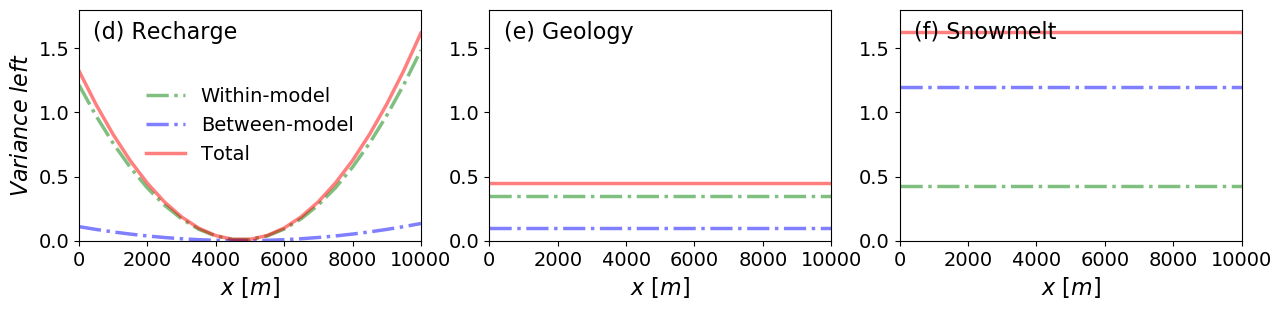

In [83]:
# Plot figure
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(x, SSW_A, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_A, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_A + SSB_A, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
plt.ylabel('$Variance$' + ' $left$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.legend(loc='center', frameon=False)
plt.text(416, 1.575, '(d) Recharge', fontsize=16)

plt.subplot(1, 3, 2)
plt.plot(x, SSW_B, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_B, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_B + SSB_B, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
# plt.ylabel('$Variance$' + ' $left$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.text(416, 1.575, '(e) Geology', fontsize=16)

plt.subplot(1, 3, 3)
plt.plot(x, SSW_C, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_C, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_C + SSB_C, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
# plt.ylabel('$Variance$' + ' $left$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.text(416, 1.575, '(f) Snowmelt', fontsize=16)

plt.show()


## Within- and between- model variacne reduction

In [85]:
# Global parameter settings
nx = 21
L = 10000
x = np.linspace(0, L, nx, endpoint=True)
N = 300
Ma, Mb, Mc = 2, 2, 2
PMA = np.array([0.5, 0.5])
PMB = np.array([0.5, 0.5])
PMC = np.array([0.5, 0.5])

def ANOVA_Var_Reduction_Process_A(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var_delta = np.var(Y) 
    
    # Analysis of variance reduction for process A
    E_t_a = np.zeros([Ma, Mb, Mc, N])
    V_t_a = np.zeros([Ma, Mb, Mc])
    V_c = np.zeros([Ma, Mb])
    V_b = np.zeros(Ma)
    
    # The first item: witinin-model variance reduction
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                for j in range (N):
                    E_t_a[i, k, m, j] = np.mean(Y[i, j, k, :, m, :])
                V_t_a[i, k, m] = np.var(E_t_a[i, k, m, :])
            V_c[i, k] = np.sum(PMC * V_t_a[i, k, :])
        V_b[i] = np.sum(PMB * V_c[i, :])
    V_a = np.sum(PMB * V_b)
    
    # The second item: between-model variance reduction
    
    # Compute the mean
    # Note that since the process models are equally weighted, we just use np.mean
    # Otherwise, you have to use the defination of mean
    E_delta = np.mean(Y)
       
    # Compute the between-model variance reduction
    item_I = np.zeros([Ma, Mb, Mc])
    E_t_a2 = np.zeros([Ma, Mb, Mc, N])
    item_II = np.zeros([Ma, Mb, Mc])
    item = np.zeros([Ma, Mb, Mc])
    E_c2 = np.zeros([Ma, Mb])
    E_b2 = np.zeros([Ma])
    
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                item_I[i, k, m] = (np.mean(Y[i, :, k, :, m, :]) - E_delta)**2
                for j in range(N):
                    E_t_a2[i, k, m, j] = (np.mean(Y[i, j, k, :, m, :]) -  np.mean(Y[i, j, :, :, :, :]))**2
                item_II[i, k, m] = np.mean(E_t_a2[i, k, m, :])
                item[i, k, m] = item_I[i, k, m] - item_II[i, k, m]
                
            E_c2[i, k] = np.sum(PMC * item[i, k, :])
        E_b2[i] = np.sum(PMB * E_c2[i, :])
    E_a2 = np.sum(PMA * E_b2[i])
            
    # Compute the total process sensitivity
    SI_A = (V_a + E_a2) / Var_delta
    # print(SI_A)

    return V_a, E_a2


def ANOVA_Var_Reduction_Process_B(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var_delta = np.var(Y) 
    
    # Analysis of variance reduction for process A
    E_t_b = np.zeros([Ma, Mb, Mc, N])
    V_t_b = np.zeros([Ma, Mb, Mc])
    V_c = np.zeros([Ma, Mb])
    V_b = np.zeros(Ma)
    
    # The first item: witinin-model variance reduction
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                for l in range (N):
                    E_t_b[i, k, m, l] = np.mean(Y[i, :, k, l, m, :])
                V_t_b[i, k, m] = np.var(E_t_b[i, k, m, :])
            V_c[i, k] = np.sum(PMC * V_t_b[i, k, :])
        V_b[i] = np.sum(PMB * V_c[i, :])
    V_a = np.sum(PMB * V_b)
    
    # The second item: between-model variance reduction
    
    # Compute the mean
    # Note that since the process models are equally weighted, we just use np.mean
    # Otherwise, you have to use the defination of mean
    E_delta = np.mean(Y)
       
    # Compute the between-model variance reduction
    item_I = np.zeros([Ma, Mb, Mc])
    E_t_a2 = np.zeros([Ma, Mb, Mc, N])
    item_II = np.zeros([Ma, Mb, Mc])
    item = np.zeros([Ma, Mb, Mc])
    E_c2 = np.zeros([Ma, Mb])
    E_b2 = np.zeros([Ma])
    
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                item_I[i, k, m] = (np.mean(Y[i, :, k, :, m, :]) - E_delta)**2
                for l in range(N):
                    E_t_a2[i, k, m, l] = (np.mean(Y[i, :, k, l, m, :]) -  np.mean(Y[:, :, k, l, :, :]))**2
                item_II[i, k, m] = np.mean(E_t_a2[i, k, m, :])
                item[i, k, m] = item_I[i, k, m] - item_II[i, k, m]
                
            E_c2[i, k] = np.sum(PMC * item[i, k, :])
        E_b2[i] = np.sum(PMB * E_c2[i, :])
    E_a2 = np.sum(PMA * E_b2[i])
            
    # Compute the total process sensitivity
    SI_B = (V_a + E_a2) / Var_delta
    # print(SI_B)

    return V_a, E_a2


def ANOVA_Var_Reduction_Process_C(Y):
    # Compute the variance
    # Note that since the process models are equally weighted, we just use np.var
    # Otherwise, you have to use the defination of variance
    Var_delta = np.var(Y) 
    
    # Analysis of variance reduction for process A
    E_t_c = np.zeros([Ma, Mb, Mc, N])
    V_t_c = np.zeros([Ma, Mb, Mc])
    V_c = np.zeros([Ma, Mb])
    V_b = np.zeros(Ma)
    
    # The first item: witinin-model variance reduction
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                for n in range (N):
                    E_t_c[i, k, m, n] = np.mean(Y[i, :, k, :, m, n])
                V_t_c[i, k, m] = np.var(E_t_c[i, k, m, :])
            V_c[i, k] = np.sum(PMC * V_t_c[i, k, :])
        V_b[i] = np.sum(PMB * V_c[i, :])
    V_a = np.sum(PMB * V_b)
    
    # The second item: between-model variance reduction
    
    # Compute the mean
    # Note that since the process models are equally weighted, we just use np.mean
    # Otherwise, you have to use the defination of mean
    E_delta = np.mean(Y)
       
    # Compute the between-model variance reduction
    item_I = np.zeros([Ma, Mb, Mc])
    E_t_a2 = np.zeros([Ma, Mb, Mc, N])
    item_II = np.zeros([Ma, Mb, Mc])
    item = np.zeros([Ma, Mb, Mc])
    E_c2 = np.zeros([Ma, Mb])
    E_b2 = np.zeros([Ma])
    
    for i in range(Ma):
        for k in range(Mb):
            for m in range(Mc):
                item_I[i, k, m] = (np.mean(Y[i, :, k, :, m, :]) - E_delta)**2
                for n in range(N):
                    E_t_a2[i, k, m, n] = (np.mean(Y[i, :, k, :, m, n]) -  np.mean(Y[:, :, :, :, m, n]))**2
                item_II[i, k, m] = np.mean(E_t_a2[i, k, m, :])
                item[i, k, m] = item_I[i, k, m] - item_II[i, k, m]
                
            E_c2[i, k] = np.sum(PMC * item[i, k, :])
        E_b2[i] = np.sum(PMB * E_c2[i, :])
    E_a2 = np.sum(PMA * E_b2[i])
            
    # Compute the total process sensitivity
    SI_C = (V_a + E_a2) / Var_delta
    # print(SI_C)

    return V_a, E_a2


# Compute the within- and between- model variance left
SSW_A = np.zeros(nx)
SSW_B = np.zeros(nx)
SSW_C = np.zeros(nx)
SSB_A = np.zeros(nx)
SSB_B = np.zeros(nx)
SSB_C = np.zeros(nx)
for ix in range(nx):
    print('Computing within- and between- model variance reduction for ix =', ix)
    SSW_A[ix], SSB_A[ix] = ANOVA_Var_Reduction_Process_A(Y[ix])
    SSW_B[ix], SSB_B[ix] = ANOVA_Var_Reduction_Process_B(Y[ix])
    SSW_C[ix], SSB_C[ix] = ANOVA_Var_Reduction_Process_C(Y[ix])

Computing within- and between- model variance reduction for ix = 0
Computing within- and between- model variance reduction for ix = 1
Computing within- and between- model variance reduction for ix = 2
Computing within- and between- model variance reduction for ix = 3
Computing within- and between- model variance reduction for ix = 4
Computing within- and between- model variance reduction for ix = 5
Computing within- and between- model variance reduction for ix = 6
Computing within- and between- model variance reduction for ix = 7
Computing within- and between- model variance reduction for ix = 8
Computing within- and between- model variance reduction for ix = 9
Computing within- and between- model variance reduction for ix = 10
Computing within- and between- model variance reduction for ix = 11
Computing within- and between- model variance reduction for ix = 12
Computing within- and between- model variance reduction for ix = 13
Computing within- and between- model variance reduction fo

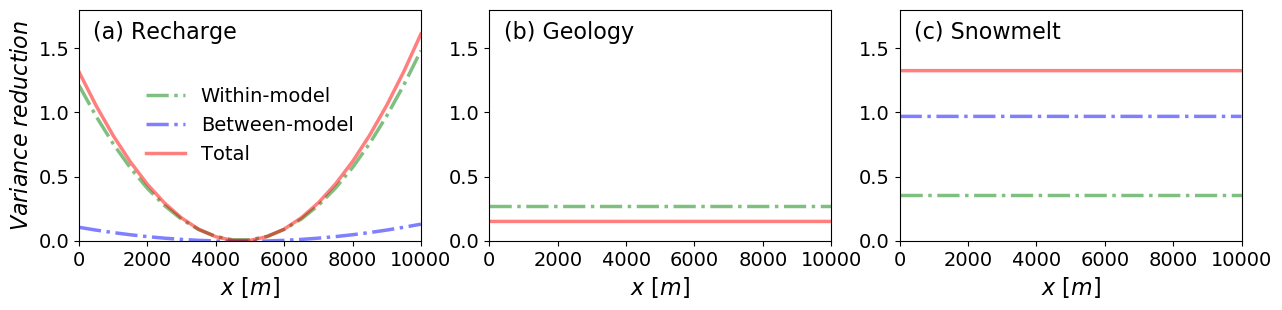

In [87]:
# Plot figure
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(x, SSW_A, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_A, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_A + SSB_A, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
plt.ylabel('$Variance$' + ' $reduction$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.legend(loc='center', frameon=False)
plt.text(416, 1.575, '(a) Recharge', fontsize=16)

plt.subplot(1, 3, 2)
plt.plot(x, SSW_B, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_B, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_B + SSB_B, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
# plt.ylabel('$Variance$' + ' $reduction$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.text(416, 1.575, '(b) Geology', fontsize=16)

plt.subplot(1, 3, 3)
plt.plot(x, SSW_C, label='Within-model', linestyle='-.', lw=2.5, color='g', alpha=0.5)
plt.plot(x, SSB_C, label='Between-model', linestyle='-.', lw=2.5, color='b', alpha=0.5)
plt.plot(x, SSW_C + SSB_C, label='Total', linestyle='-', lw=2.5, color='r', alpha=0.5)
plt.xlabel('$x$' + ' $[m]$', fontsize=16)
# plt.ylabel('$Variance$' + ' $reduction$', fontsize=16)
plt.xlim([0, 10000])
plt.ylim([0, 1.8])
plt.text(416, 1.575, '(c) Snowmelt', fontsize=16)

plt.show()


## Second-order process interaction

### Compute the process interaction between recharge process and geology process

In [89]:
# @nb.jit(fastmath=True)
def IPS_Process_AB(Y):
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tc_d = np.zeros([Ma, Mb, N, N, Mc])
    E_c_d = np.zeros([Ma, Mb, N, N])
    E_c_d2 = np.zeros([Ma, Mb, N, N])
    
    E_tb_d = np.zeros([Ma, Mb])
    E_tb_d2 = np.zeros([Ma, Mb])
    E_b_d = np.zeros([Ma])
    E_b_d2 = np.zeros([Ma])

    for i in range(Ma):
        for k in range(Mb):
            for j in range(N):
                for l in range(N):
                    for m in range(Mc):
                        E_tc_d[i, k, j, l, m] = np.mean(Y[i, j, k, l, m, :])
                    E_c_d[i, k, j, l] = PMC[0] * E_tc_d[i, k, j, l, 0] + PMC[1] * E_tc_d[i, k, j, l, 1]
                    E_c_d2[i, k, j, l] = E_c_d[i, k, j, l]**2
            E_tb_d[i, k] = np.mean(E_c_d[i, k, :, :])
            E_tb_d2[i, k] = np.mean(E_c_d2[i, k, :, :])
        E_b_d[i] = PMB[0] * E_tb_d[i, 0] + PMB[1] * E_tb_d[i, 1]
        E_b_d2[i] = PMB[0] * E_tb_d2[i, 0] + PMB[1] * E_tb_d2[i, 1]
    E_a_d = PMA[0] * E_b_d[0] + PMA[1] * E_b_d[1]
    E_a_d2 = PMA[0] * E_b_d2[0] + PMA[1] * E_b_d2[1]
        
    Var_AB = E_a_d2 - E_a_d**2
    IPS_Process_AB = Var_AB / (Var_t_d + 1e-20) - SI_Process_A(Y) - SI_Process_B(Y)
    
    
    return IPS_Process_AB 

# Over the domain
IPS_Process_RG = np.zeros(nx)

for ix in range(nx):
    print('Computing process interaction between recharge process and geology process for ix =', ix)
    IPS_Process_RG[ix] = IPS_Process_AB(Y[ix])

Computing process interaction between recharge process and geology process for ix = 0
Computing process interaction between recharge process and geology process for ix = 1
Computing process interaction between recharge process and geology process for ix = 2
Computing process interaction between recharge process and geology process for ix = 3
Computing process interaction between recharge process and geology process for ix = 4
Computing process interaction between recharge process and geology process for ix = 5
Computing process interaction between recharge process and geology process for ix = 6
Computing process interaction between recharge process and geology process for ix = 7
Computing process interaction between recharge process and geology process for ix = 8
Computing process interaction between recharge process and geology process for ix = 9
Computing process interaction between recharge process and geology process for ix = 10
Computing process interaction between recharge proces

### Compute the process interaction between recharge process and snowmelt process

In [92]:
# @nb.jit(fastmath=True)
def IPS_Process_AC(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_tb_d = np.zeros([Ma, Mc, N, N, Mb])
    E_b_d = np.zeros([Ma, Mc, N, N])
    E_b_d2 = np.zeros([Ma, Mc, N, N])
    E_tc_d = np.zeros([Ma, Mc])
    E_tc_d2 = np.zeros([Ma, Mc])
    E_c_d = np.zeros([Ma])
    E_c_d2 = np.zeros([Ma])  

    for i in range(Ma):
        for m in range(Mc):
             for j in range(N):
                for n in range(N):
                    for k in range(Mb):
                        E_tb_d[i, m, j, n, k] = np.mean(Y[i, j, k, :, m, n])
                    E_b_d[i, m, j, n] = PMB[0] * E_tb_d[i, m, j, n, 0] + PMB[1] * E_tb_d[i, m, j, n, 1]
                    E_b_d2[i, m, j, n] = E_b_d[i, m, j, n]**2
             E_tc_d[i, m] = np.mean(E_b_d[i, m, :, :])
             E_tc_d2[i, m] = np.mean(E_b_d2[i, m, :, :])
        E_c_d[i] = PMC[0] * E_tc_d[i, 0] + PMC[1] * E_tc_d[i, 1]
        E_c_d2[i] = PMC[0] * E_tc_d2[i, 0] + PMC[1] * E_tc_d2[i, 1]
    E_a_d = PMA[0] * E_c_d[0] + PMA[1] * E_c_d[1]
    E_a_d2 = PMA[0] * E_c_d2[0] + PMA[1] * E_c_d2[1]
        
    Var_AC = E_a_d2 - E_a_d**2
    IPS_Process_AC = Var_AC / (Var_t_d + 1e-20) - SI_Process_A(Y) - SI_Process_C(Y)
    
    # print(Var_AC)
    return IPS_Process_AC

# Over the domain
IPS_Process_RM = np.zeros(nx)

for ix in range(nx):
    print('Computing process interaction between recharge process and snowmelt process for ix =', ix)
    IPS_Process_RM[ix] = IPS_Process_AC(Y[ix])

Computing process interaction between recharge process and snowmelt process for ix = 0
Computing process interaction between recharge process and snowmelt process for ix = 1
Computing process interaction between recharge process and snowmelt process for ix = 2
Computing process interaction between recharge process and snowmelt process for ix = 3
Computing process interaction between recharge process and snowmelt process for ix = 4
Computing process interaction between recharge process and snowmelt process for ix = 5
Computing process interaction between recharge process and snowmelt process for ix = 6
Computing process interaction between recharge process and snowmelt process for ix = 7
Computing process interaction between recharge process and snowmelt process for ix = 8
Computing process interaction between recharge process and snowmelt process for ix = 9
Computing process interaction between recharge process and snowmelt process for ix = 10
Computing process interaction between rech

### Compute the process interaction between geology process and snowmelt process

In [93]:
# @nb.jit(fastmath=True)
def IPS_Process_BC(Y):
    
    Ma = 2
    Mb = 2
    Mc = 2
    
    PMA = np.array([0.5, 0.5])
    PMB = np.array([0.5, 0.5])
    PMC = np.array([0.5, 0.5])
    
    Var_t_d = np.var(Y)
    
    E_ta_d = np.zeros([Mb, Mc, N, N, Ma])
    E_a_d = np.zeros([Mb, Mc, N, N])
    E_a_d2 = np.zeros([Mb, Mc, N, N])
    E_tc_d = np.zeros([Mb, Mc])
    E_tc_d2 = np.zeros([Mb, Mc])
    E_c_d = np.zeros([Mb])
    E_c_d2 = np.zeros([Mb])

    for k in range(Mb):
        for m in range(Mc):
            for l in range(N):
                for n in range(N):
                    for i in range(Ma):
                        E_ta_d[k, m, l, n, i] = np.mean(Y[i, :, k, l, m, n])
                    E_a_d[k, m, l, n] = PMA[0] * E_ta_d[k, m, l, n, 0] + PMA[1] * E_ta_d[k, m, l, n, 1]
                    E_a_d2[k, m, l, n] = E_a_d[k, m, l, n]**2
            E_tc_d[k, m] = np.mean(E_a_d[k, m, :, :])
            E_tc_d2[k, m] = np.mean(E_a_d2[k, m, :, :])
        E_c_d[k] = PMC[0] * E_tc_d[k, 0] + PMC[1] * E_tc_d[k, 1]
        E_c_d2[k] = PMC[0] * E_tc_d2[k, 0] + PMC[1] * E_tc_d2[k, 1]
    E_b_d = PMB[0] * E_c_d[0] + PMB[1] * E_c_d[1]
    E_b_d2 = PMB[0] * E_c_d2[0] + PMB[1] * E_c_d2[1]
        
    Var_BC = E_b_d2 - E_b_d**2
    IPS_Process_BC = Var_BC / (Var_t_d + 1e-20) - SI_Process_B(Y) - SI_Process_C(Y)
    
    # print(Var_BC)
    return IPS_Process_BC

# Over the domain
IPS_Process_GM = np.zeros(nx)

for ix in range(nx):
    print('Computing process interaction between geology process and snowmelt process for ix =', ix)
    IPS_Process_GM[ix] = IPS_Process_BC(Y[ix])

Computing process interaction between geology process and snowmelt process for ix = 0
Computing process interaction between geology process and snowmelt process for ix = 1
Computing process interaction between geology process and snowmelt process for ix = 2
Computing process interaction between geology process and snowmelt process for ix = 3
Computing process interaction between geology process and snowmelt process for ix = 4
Computing process interaction between geology process and snowmelt process for ix = 5
Computing process interaction between geology process and snowmelt process for ix = 6
Computing process interaction between geology process and snowmelt process for ix = 7
Computing process interaction between geology process and snowmelt process for ix = 8
Computing process interaction between geology process and snowmelt process for ix = 9
Computing process interaction between geology process and snowmelt process for ix = 10
Computing process interaction between geology process

### Plot the spatial variation

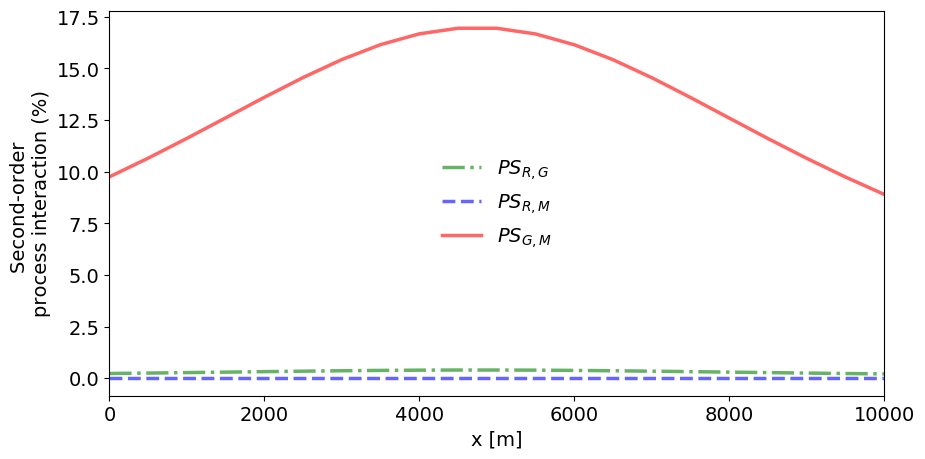

In [105]:
plt.figure(figsize=(10, 5))

plt.plot(X, IPS_Process_RG * 100, label='$PS_{R,G}$', color='g', linestyle='-.', lw=2.5, alpha=0.6)
plt.plot(X, IPS_Process_RM * 100, label='$PS_{R,M}$', color='b', linestyle='--',  lw=2.5, alpha=0.6)
plt.plot(X, IPS_Process_GM * 100, label='$PS_{G,M}$', color='r', linestyle='-',  lw=2.5, alpha=0.6)

plt.xlabel('x [m]', fontsize=14)
plt.ylabel('Second-order \nprocess interaction (%)',  fontsize=14)
plt.xlim([0, L])
# plt.ylim([0, 100])
plt.legend(frameon=False, loc='center')

plt.show()

In [119]:
# Obtain the seed and save it
import pickle 

st = np.random.get_state()
with open('st.pickle', 'wb') as fobj:
    pickle.dump(st, fobj)
    
with open('st.pickle', 'rb') as fobj:
     st = pickle.load(fobj)

# Set the random state 
np.random.set_state(st)